# Part 1: Environment Setup & Basic Utilities


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pyarrow.parquet as pq
import warnings
import matplotlib.dates as mdates
import requests
from IPython.display import display, HTML

# Ignore warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Not running in Google Colab or Drive already mounted.")

CITIBIKE_PATH = '/content/drive/My Drive/capstone_project_25/datasets/citi_bike'
TAXI_PATH = '/content/drive/My Drive/capstone_project_25/datasets/nyc_taxi'
OUTPUT_PATH = '/content/drive/My Drive/capstone_project_25/output'

try:
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    print(f"Output directory created/confirmed at: {OUTPUT_PATH}")
except Exception as e:
    print(f"Error creating output directory: {e}")

# Check paths
print(f"Citi Bike data path exists: {os.path.exists(CITIBIKE_PATH)}")
print(f"NYC Taxi data path exists: {os.path.exists(TAXI_PATH)}")

def list_files(directory, name):
    """Lists files in the given directory if it exists."""
    if os.path.exists(directory):
        print(f"\n{name} files:")
        for file in os.listdir(directory):
            print(f" - {file}")
    else:
        print(f"\n{name} path does not exist.")

# Show files
list_files(CITIBIKE_PATH, "Citi Bike")
list_files(TAXI_PATH, "NYC Taxi")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Output directory created/confirmed at: /content/drive/My Drive/capstone_project_25/output
Citi Bike data path exists: True
NYC Taxi data path exists: True

Citi Bike files:
 - 202401-citibike-tripdata.csv
 - 202402-citibike-tripdata.csv
 - 202403-citibike-tripdata.csv
 - 202404-citibike-tripdata.csv
 - 202406-citibike-tripdata.csv
 - 202407-citibike-tripdata.csv
 - 202408-citibike-tripdata.csv
 - 202409-citibike-tripdata.csv
 - 202410-citibike-tripdata.csv
 - 202411-citibike-tripdata.csv
 - 202412-citibike-tripdata.csv
 - 202405-citibike-tripdata.csv

NYC Taxi files:
 - yellow_tripdata_2024-01.parquet
 - yellow_tripdata_2024-02.parquet
 - yellow_tripdata_2024-03.parquet
 - yellow_tripdata_2024-04.parquet
 - yellow_tripdata_2024-05.parquet
 - yellow_tripdata_2024-06.parquet
 - yellow_tripdata_2024-07.parquet
 - yellow_tripdat

# Part 2: Data Loading & Aggregation

In [ ]:
def load_citibike_data(month, year):
    """
    Load and preprocess Citi Bike data for a specific month/year.
    """
    filename = f"{year}{month:02d}-citibike-tripdata.csv"
    filepath = os.path.join(CITIBIKE_PATH, filename)

    try:
        if not os.path.exists(filepath):
            print(f"Warning: {filename} not found")
            return None

        print(f"Loading {filename}...")
        df = pd.read_csv(filepath, encoding='utf-8', encoding_errors='ignore')

        # Convert times
        df['started_at'] = pd.to_datetime(df['started_at'], errors='coerce')
        df['ended_at']   = pd.to_datetime(df['ended_at'], errors='coerce')

        # Compute trip duration in seconds
        df['trip_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds()

        # Extract date
        df['date'] = df['started_at'].dt.date

        # Standardize column names
        column_mapping = {
            'ride_id': 'ride_id',
            'start_station_id': 'start_station_id',
            'end_station_id': 'end_station_id'
        }
        df.rename(columns={k: v for k, v in column_mapping.items() if k in df.columns}, inplace=True)

        # Drop rows with missing in critical columns
        critical_cols = ['ride_id', 'trip_duration', 'start_station_id', 'end_station_id', 'date']
        df.dropna(subset=[c for c in critical_cols if c in df.columns], inplace=True)

        # Filter out extreme durations (e.g., negative or >24 hours)
        df = df[(df['trip_duration'] > 0) & (df['trip_duration'] < 86400)]

        return df

    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None


def load_taxi_data(month, year):
    """
    Load and preprocess Yellow Taxi data for a specific month/year.
    """
    filename = f"yellow_tripdata_{year}-{month:02d}.parquet"
    filepath = os.path.join(TAXI_PATH, filename)

    try:
        if not os.path.exists(filepath):
            print(f"Warning: {filename} not found")
            return None

        print(f"Loading {filename}...")
        df = pd.read_parquet(filepath)

        # Handle pickup datetime variations
        pickup_col = next((col for col in df.columns if 'pickup' in col.lower()), None)
        if pickup_col:
            df[pickup_col] = pd.to_datetime(df[pickup_col], errors='coerce')
            df['date'] = df[pickup_col].dt.date
        else:
            print("Warning: No pickup datetime column found.")
            return None

        # Standardize columns
        column_mapping = {
            'fare_amount': 'fare_amount',
            'trip_distance': 'trip_distance',
            'passenger_count': 'passenger_count',
            'VendorID': 'vendor_id'
        }
        df.rename(columns={k: v for k, v in column_mapping.items() if k in df.columns}, inplace=True)

        # Remove invalid trips
        df = df[(df['fare_amount'] > 0) & (df['trip_distance'] > 0)]

        return df

    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None


def aggregate_by_date(df, mode='citibike'):
    """
    Aggregate trip data by date (1 row per date).
    """
    if df is None or df.empty:
        print("Warning: DataFrame is empty or None.")
        return None

    # Required columns
    if mode == 'citibike':
        required_cols = {'ride_id', 'trip_duration', 'date'}
    else:
        required_cols = {'vendor_id', 'fare_amount', 'trip_distance', 'passenger_count', 'date'}

    missing_cols = required_cols - set(df.columns)
    if missing_cols:
        print(f"Warning: Missing columns in {mode} data: {missing_cols}")
        return None

    # Group by date & calc metrics
    if mode == 'citibike':
        daily_agg = df.groupby('date').agg(
            trip_count=('ride_id', 'count'),
            avg_trip_duration=('trip_duration', 'mean'),
            median_trip_duration=('trip_duration', 'median')
        ).reset_index()
    else:
        daily_agg = df.groupby('date').agg(
            trip_count=('vendor_id', 'count'),
            avg_fare=('fare_amount', 'mean'),
            avg_distance=('trip_distance', 'mean'),
            avg_passenger_count=('passenger_count', 'mean'),
            total_revenue=('fare_amount', 'sum')
        ).reset_index()

    # Convert to datetime
    daily_agg['date'] = pd.to_datetime(daily_agg['date'])

    # Add day of week and day name
    daily_agg['day_of_week'] = daily_agg['date'].dt.dayofweek
    daily_agg['day_name'] = daily_agg['date'].dt.day_name()
    daily_agg['month'] = daily_agg['date'].dt.month
    daily_agg['month_name'] = daily_agg['date'].dt.month_name()

    return daily_agg

# Part 3: EDA Visualization & Time-Series Forecasting


In [ ]:
def explore_time_series(df, metric, title, mode='citibike', save_path=None):
    """Simple time series plot + 7-day MA."""
    if df is None or len(df) == 0:
        print("No data to visualize.")
        return

    plt.figure(figsize=(15, 6))
    plt.plot(df['date'], df[metric], 'b-', alpha=0.7, label=metric)
    df['7d_ma'] = df[metric].rolling(window=7).mean()
    plt.plot(df['date'], df['7d_ma'], 'r-', linewidth=2, label='7-day MA')
    plt.title(f"{title} - {mode.capitalize()}", fontsize=16)
    plt.xlabel('Date')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Format x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=45)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    plt.show()

    print(f"Descriptive statistics for {metric}:")
    print(df[metric].describe())


def create_interactive_plot(df, metric, title, mode='citibike'):
    """Plotly interactive time series."""
    if df is None or len(df) == 0:
        print("No data to visualize.")
        return

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df['date'], y=df[metric],
        mode='lines', name=metric.replace('_', ' ').title(),
        line=dict(width=1)
    ))
    df['7d_ma'] = df[metric].rolling(window=7).mean()
    fig.add_trace(go.Scatter(
        x=df['date'], y=df['7d_ma'],
        mode='lines', name='7-day MA',
        line=dict(width=2)
    ))
    fig.update_layout(
        title=f"{title} - {mode.capitalize()}",
        xaxis_title='Date',
        yaxis_title=metric.replace('_', ' ').title(),
        template='plotly_white',
        height=500,
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
    )
    return fig


def analyze_temporal_patterns(df, metric):
    """Boxplots by day_of_week and month."""
    if df is None or len(df) == 0:
        print("No data to analyze.")
        return

    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.day_name()
    df['month'] = df['date'].dt.month_name()

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    sns.boxplot(x='day_of_week', y=metric, data=df, ax=axes[0], order=day_order)
    axes[0].set_title(f'{metric.title()} by Day of Week')
    axes[0].tick_params(axis='x', rotation=45)

    month_order = ['January','February','March','April','May','June',
                   'July','August','September','October','November','December']
    sns.boxplot(x='month', y=metric, data=df, ax=axes[1], order=month_order)
    axes[1].set_title(f'{metric.title()} by Month')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


# Install necessary forecasting packages
try:
    import prophet
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.seasonal import seasonal_decompose
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    print("Forecasting packages already installed.")
except ImportError:
    print("Installing forecasting packages...")
    !pip install -q prophet statsmodels
    # Skip pmdarima due to compatibility issues
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.seasonal import seasonal_decompose
    from prophet import Prophet
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def prepare_for_forecasting(df, target_col):
    """Return forecast_df & prophet_df (ds,y) sorted by date."""
    if df is None or len(df) == 0:
        return None, None
    df = df.sort_values('date')
    forecast_df = df[['date', target_col]].copy()
    prophet_df = forecast_df.rename(columns={'date':'ds', target_col:'y'})
    return forecast_df, prophet_df


def train_arima_model(df, target_col, order=(7,1,7)):
    """Fit ARIMA model."""
    forecast_df, _ = prepare_for_forecasting(df, target_col)
    if forecast_df is None:
        return None, None

    ts_data = forecast_df.set_index('date')[target_col]
    try:
        model = ARIMA(ts_data, order=order)
        arima_model = model.fit()
        predictions = arima_model.predict(dynamic=False)
        return arima_model, predictions
    except Exception as e:
        print(f"Error training ARIMA: {e}")
        return None, None


def train_prophet_model(df, target_col):
    """Fit Prophet model in-sample."""
    forecast_df, prophet_df = prepare_for_forecasting(df, target_col)
    if forecast_df is None or prophet_df is None:
        return None, None
    try:
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=0.05
        )
        model.add_country_holidays(country_name='US')
        model.fit(prophet_df)

        future = model.make_future_dataframe(periods=0)
        forecast = model.predict(future)

        # Align predictions
        prophet_results = pd.merge(
            forecast_df[['date']],
            forecast[['ds','yhat']],
            left_on='date',
            right_on='ds',
            how='left'
        )
        return model, prophet_results
    except Exception as e:
        print(f"Error training Prophet: {e}")
        return None, None


def evaluate_forecast(actual, predicted):
    """Print MSE, RMSE, MAE, R2."""
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R^2: {r2:.4f}")
    return {'mse':mse,'rmse':rmse,'mae':mae,'r2':r2}


def plot_forecast_results(dates, actual, predicted, model_name, metric, save_path=None):
    """Plot actual vs forecast."""
    plt.figure(figsize=(15,6))
    plt.plot(dates, actual, 'b-', label='Actual', alpha=0.7)
    plt.plot(dates, predicted, 'r-', label=f'{model_name} Forecast', linewidth=2)
    plt.title(f'{model_name} vs Actual - {metric.title()}', fontsize=15)
    plt.xlabel('Date')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Format x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=45)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    plt.show()

Forecasting packages already installed.


# Part 4: Anomaly Detection & Correlation + Dashboard


In [ ]:
def detect_anomalies_residual(actual, predicted, threshold=2.0):
    """Residual-based anomaly detection using Z-score."""
    residuals = actual - predicted
    mean_resid = residuals.mean()
    std_resid  = residuals.std()
    z_scores   = (residuals - mean_resid) / std_resid
    anomalies  = (abs(z_scores) > threshold)
    return anomalies, z_scores


def detect_anomalies_stl(df, target_col, period=7, threshold=2.0):
    """STL-based anomaly detection."""
    if df is None or df.empty:
        return None, None, None
    ts_data = df.set_index('date')[target_col].sort_index()
    try:
        stl_result = seasonal_decompose(ts_data, period=period)
        resid = stl_result.resid.dropna()
        mean_resid = resid.mean()
        std_resid  = resid.std()
        z_scores   = (resid - mean_resid) / std_resid
        anomalies  = abs(z_scores) > threshold
        return anomalies, z_scores, stl_result
    except Exception as e:
        print(f"Error in STL decomposition: {e}")
        return None, None, None


def plot_anomalies(dates, values, anomalies, title, metric, save_path=None):
    """Plot time series with anomalies highlighted."""
    plt.figure(figsize=(15,6))
    plt.plot(dates, values, 'b-', alpha=0.7, label=metric.title())
    if any(anomalies):
        plt.scatter(dates[anomalies], values[anomalies], color='red', s=50, label='Anomalies')
    plt.title(title, fontsize=15)
    plt.xlabel('Date')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Format x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=45)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    plt.show()


def ensemble_anomaly_detection(df, target_col, models=None, methods=None, threshold=2.0):
    """Combine multiple anomaly detection methods (residual, stl, iqr)."""
    if df is None or df.empty:
        return None

    if methods is None:
        methods = ['residual','stl','iqr']

    # Sort by date, create new df
    results = df.sort_values('date').reset_index(drop=True)
    anomaly_flags = np.zeros(len(results), dtype=bool)

    # 1) Residual-based
    if 'residual' in methods and models is not None:
        for model_name, (model, preds) in models.items():
            if model_name == 'prophet' and preds is not None:
                # preds is a df
                if len(preds) == len(results):
                    anomalies,_ = detect_anomalies_residual(results[target_col].values, preds['yhat'].values, threshold)
                    results[f'{model_name}_anomaly'] = anomalies
                    anomaly_flags = anomaly_flags | anomalies
                else:
                    print(f"[Warning] Prophet predictions length != data length.")
            elif model_name == 'arima' and preds is not None:
                if len(preds) == len(results):
                    anomalies,_ = detect_anomalies_residual(results[target_col].values, preds.values, threshold)
                    results[f'{model_name}_anomaly'] = anomalies
                    anomaly_flags = anomaly_flags | anomalies
                else:
                    print(f"[Warning] ARIMA predictions length != data length.")

    # 2) STL-based
    if 'stl' in methods:
        anom_stl, _, _ = detect_anomalies_stl(results, target_col, period=7, threshold=threshold)
        if anom_stl is not None:
            # Convert anom_stl (DatetimeIndex) -> boolean array
            date_index = pd.to_datetime(results['date'])
            stl_mask = np.zeros(len(results), dtype=bool)
            for dt_idx, val in anom_stl.items():
                if val:
                    # find matching row
                    match = np.where(date_index == dt_idx)[0]
                    if len(match)>0:
                        stl_mask[match[0]] = True
            results['stl_anomaly'] = stl_mask
            anomaly_flags = anomaly_flags | stl_mask

    # 3) IQR-based
    if 'iqr' in methods:
        Q1 = results[target_col].quantile(0.25)
        Q3 = results[target_col].quantile(0.75)
        IQR= Q3 - Q1
        iqr_anomalies = (results[target_col] < (Q1-1.5*IQR)) | (results[target_col] > (Q3+1.5*IQR))
        results['iqr_anomaly'] = iqr_anomalies
        anomaly_flags = anomaly_flags | iqr_anomalies

    results['is_anomaly'] = anomaly_flags
    return results


def create_dashboard(citibike_anomalies, taxi_anomalies, target_col, save_path=None):
    """Simple Plotly dashboard to compare anomalies."""
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=['Citi Bike Anomalies','Taxi Anomalies'],
        shared_xaxes=True,
        vertical_spacing=0.1
    )

    # Citi Bike
    if citibike_anomalies is not None and not citibike_anomalies.empty:
        fig.add_trace(
            go.Scatter(
                x=citibike_anomalies['date'],
                y=citibike_anomalies[target_col],
                mode='lines',
                name='Citi Bike'
            ), row=1, col=1
        )
        c_mask = citibike_anomalies['is_anomaly']
        if c_mask.any():
            fig.add_trace(
                go.Scatter(
                    x=citibike_anomalies.loc[c_mask,'date'],
                    y=citibike_anomalies.loc[c_mask,target_col],
                    mode='markers',
                    name='CB Anomalies',
                    marker=dict(color='red', size=8, symbol='circle')
                ), row=1, col=1
            )

    # Taxi
    if taxi_anomalies is not None and not taxi_anomalies.empty:
        fig.add_trace(
            go.Scatter(
                x=taxi_anomalies['date'],
                y=taxi_anomalies[target_col],
                mode='lines',
                name='Taxi'
            ), row=2, col=1
        )
        t_mask = taxi_anomalies['is_anomaly']
        if t_mask.any():
            fig.add_trace(
                go.Scatter(
                    x=taxi_anomalies.loc[t_mask,'date'],
                    y=taxi_anomalies.loc[t_mask,target_col],
                    mode='markers',
                    name='Taxi Anomalies',
                    marker=dict(color='red', size=8, symbol='circle')
                ), row=2, col=1
            )

    fig.update_layout(
        title=f'Anomaly Dashboard - {target_col.title()}',
        height=800, width=1000,
        showlegend=True,
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
        template='plotly_white'
    )
    fig.update_xaxes(title_text='Date', row=2, col=1)
    fig.update_yaxes(title_text=target_col.title(), row=1, col=1)
    fig.update_yaxes(title_text=target_col.title(), row=2, col=1)

    if save_path:
        fig.write_html(save_path)
        print(f"Dashboard saved to {save_path}")

    return fig


# Part 5: Main Execution

In [ ]:
# We'll load 2024 data: Jan 1 to Dec 31
start_date = '2024-01-01'
end_date   = '2024-12-31'

start = datetime.strptime(start_date,'%Y-%m-%d')
end   = datetime.strptime(end_date,'%Y-%m-%d')

date_range = []
current = start
while current <= end:
    date_range.append((current.year, current.month))
    # move to next month
    if current.month == 12:
        current = datetime(current.year+1,1,1)
    else:
        current = datetime(current.year, current.month+1,1)

print(f"Processing data for: {start_date} to {end_date}")
print(f"Months to process: {len(date_range)}")

Processing data for: 2024-01-01 to 2024-12-31
Months to process: 12


# Part 5.1: Load & Aggregate Citi Bike Data

In [ ]:
citibike_monthly = []
for y, m in tqdm(date_range, desc="Loading Citi Bike"):
    df = load_citibike_data(m, y)
    if df is not None:
        daily_agg = aggregate_by_date(df, mode='citibike')
        if daily_agg is not None:
            citibike_monthly.append(daily_agg)

# Concatenate
if citibike_monthly:
    citibike_data = pd.concat(citibike_monthly, ignore_index=True)
    # Now drop duplicates on 'date'
    citibike_data.drop_duplicates(subset='date', inplace=True)
    # Filter to 2024 only
    citibike_data = citibike_data[
        (citibike_data['date'] >= pd.to_datetime(start_date)) &
        (citibike_data['date'] <= pd.to_datetime(end_date))
    ]
    citibike_data.sort_values('date', inplace=True)
    citibike_data.reset_index(drop=True, inplace=True)
    print(f"Citi Bike data loaded: {len(citibike_data)} rows")

    # Quick check
    unique_days = citibike_data['date'].nunique()
    print("Unique days in Citi Bike data:", unique_days)
    print("Total rows in Citi Bike data:", len(citibike_data))

    # Save processed data
    citibike_data.to_csv(os.path.join(OUTPUT_PATH, 'citibike_daily_2024.csv'), index=False)
    print(f"Saved processed Citi Bike data to {os.path.join(OUTPUT_PATH, 'citibike_daily_2024.csv')}")
else:
    citibike_data = None
    print("No Citi Bike data loaded")

Loading Citi Bike:   0%|          | 0/12 [00:00<?, ?it/s]

Loading 202401-citibike-tripdata.csv...
Loading 202402-citibike-tripdata.csv...
Loading 202403-citibike-tripdata.csv...
Loading 202404-citibike-tripdata.csv...
Loading 202405-citibike-tripdata.csv...
Loading 202406-citibike-tripdata.csv...
Loading 202407-citibike-tripdata.csv...
Loading 202408-citibike-tripdata.csv...
Loading 202409-citibike-tripdata.csv...
Loading 202410-citibike-tripdata.csv...
Loading 202411-citibike-tripdata.csv...
Loading 202412-citibike-tripdata.csv...
Citi Bike data loaded: 366 rows
Unique days in Citi Bike data: 366
Total rows in Citi Bike data: 366
Saved processed Citi Bike data to /content/drive/My Drive/capstone_project_25/output/citibike_daily_2024.csv


# Part 5.2 : Load & Aggregate Taxi Data

In [ ]:
taxi_monthly = []
for y, m in tqdm(date_range, desc="Loading Taxi"):
    df = load_taxi_data(m, y)
    if df is not None:
        daily_agg = aggregate_by_date(df, mode='taxi')
        if daily_agg is not None:
            taxi_monthly.append(daily_agg)

if taxi_monthly:
    taxi_data = pd.concat(taxi_monthly, ignore_index=True)
    taxi_data.drop_duplicates(subset='date', inplace=True)
    taxi_data = taxi_data[
        (taxi_data['date'] >= pd.to_datetime(start_date)) &
        (taxi_data['date'] <= pd.to_datetime(end_date))
    ]
    taxi_data.sort_values('date', inplace=True)
    taxi_data.reset_index(drop=True, inplace=True)
    print(f"Taxi data loaded: {len(taxi_data)} rows")

    unique_days = taxi_data['date'].nunique()
    print("Unique days in Taxi data:", unique_days)
    print("Total rows in Taxi data:", len(taxi_data))

    # Save processed data
    taxi_data.to_csv(os.path.join(OUTPUT_PATH, 'taxi_daily_2024.csv'), index=False)
    print(f"Saved processed Taxi data to {os.path.join(OUTPUT_PATH, 'taxi_daily_2024.csv')}")
else:
    taxi_data = None
    print("No Taxi data loaded")

Loading Taxi:   0%|          | 0/12 [00:00<?, ?it/s]

Loading yellow_tripdata_2024-01.parquet...
Loading yellow_tripdata_2024-02.parquet...
Loading yellow_tripdata_2024-03.parquet...
Loading yellow_tripdata_2024-04.parquet...
Loading yellow_tripdata_2024-05.parquet...
Loading yellow_tripdata_2024-06.parquet...
Loading yellow_tripdata_2024-07.parquet...
Loading yellow_tripdata_2024-08.parquet...
Loading yellow_tripdata_2024-09.parquet...
Loading yellow_tripdata_2024-10.parquet...
Loading yellow_tripdata_2024-11.parquet...
Loading yellow_tripdata_2024-12.parquet...
Taxi data loaded: 366 rows
Unique days in Taxi data: 366
Total rows in Taxi data: 366
Saved processed Taxi data to /content/drive/My Drive/capstone_project_25/output/taxi_daily_2024.csv


# Part 5.3: EDA - DATA OVERVIEW

In [ ]:
if citibike_data is not None and not citibike_data.empty:
    print("\nCiti Bike Data Sample:")
    display(citibike_data.head())

if taxi_data is not None and not taxi_data.empty:
    print("\nTaxi Data Sample:")
    display(taxi_data.head())


Citi Bike Data Sample:


,date,trip_count,avg_trip_duration,median_trip_duration,day_of_week,day_name,month,month_name
0,2024-01-01,47031,830.177434,536.578,0,Monday,1,January
1,2024-01-02,67835,707.646748,474.455,1,Tuesday,1,January
2,2024-01-03,76213,694.368737,473.298,2,Wednesday,1,January
3,2024-01-04,77272,641.213523,469.116,3,Thursday,1,January
4,2024-01-05,72233,646.122509,462.306,4,Friday,1,January



Taxi Data Sample:


,date,trip_count,avg_fare,avg_distance,avg_passenger_count,total_revenue,day_of_week,day_name,month,month_name
0,2024-01-01,75529,22.196146,4.655885,1.552044,1676452.69,0,Monday,1,January
1,2024-01-02,73007,21.385068,4.212554,1.418943,1561259.63,1,Tuesday,1,January
2,2024-01-03,79958,20.071616,3.950187,1.380718,1604886.25,2,Wednesday,1,January
3,2024-01-04,100149,18.766625,3.361159,1.355444,1879458.74,3,Thursday,1,January
4,2024-01-05,100138,18.152441,3.827213,1.371950,1817749.15,4,Friday,1,January


# Part 5.3.1: EDA - Citi Bike Analysis


Exploratory Data Analysis on Citi Bike:
Figure saved to /content/drive/My Drive/capstone_project_25/output/daily_trip_count_citibike.png


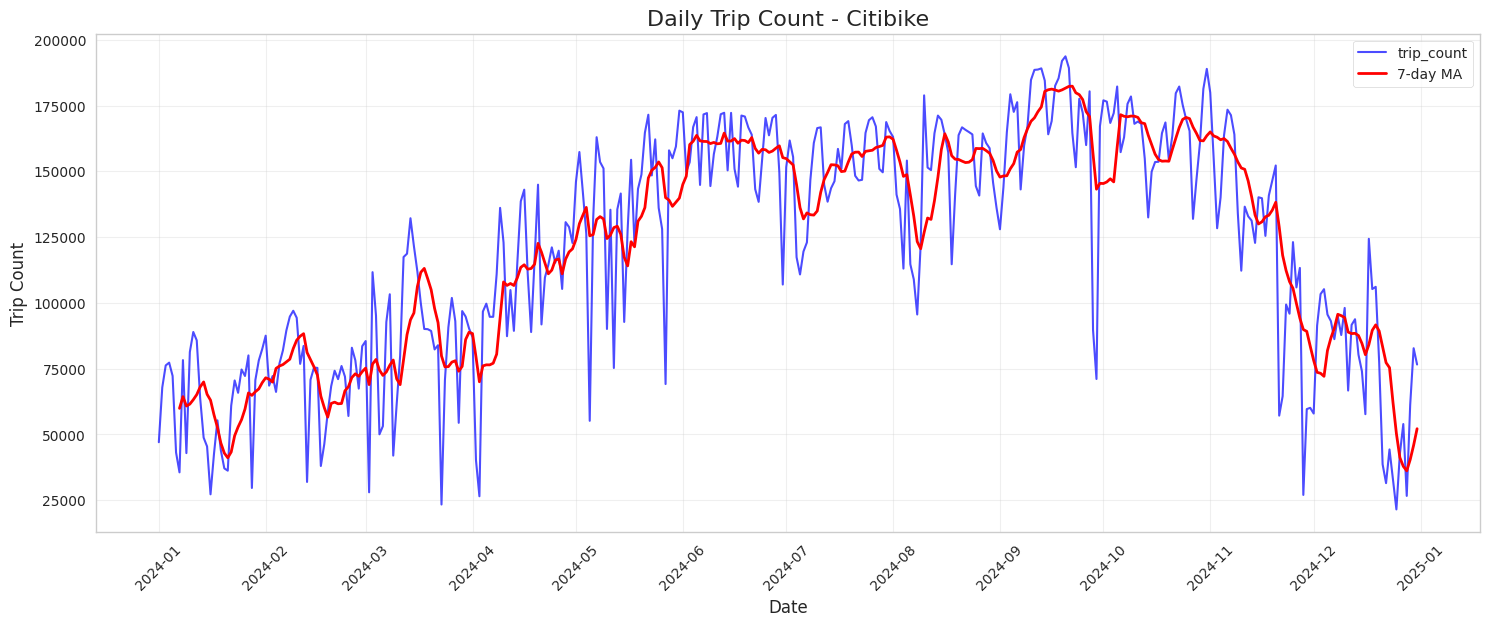

Descriptive statistics for trip_count:
count       366.000000
mean     120909.945355
std       44534.513118
min       21488.000000
25%       84292.750000
50%      129736.000000
75%      162022.500000
max      193685.000000
Name: trip_count, dtype: float64


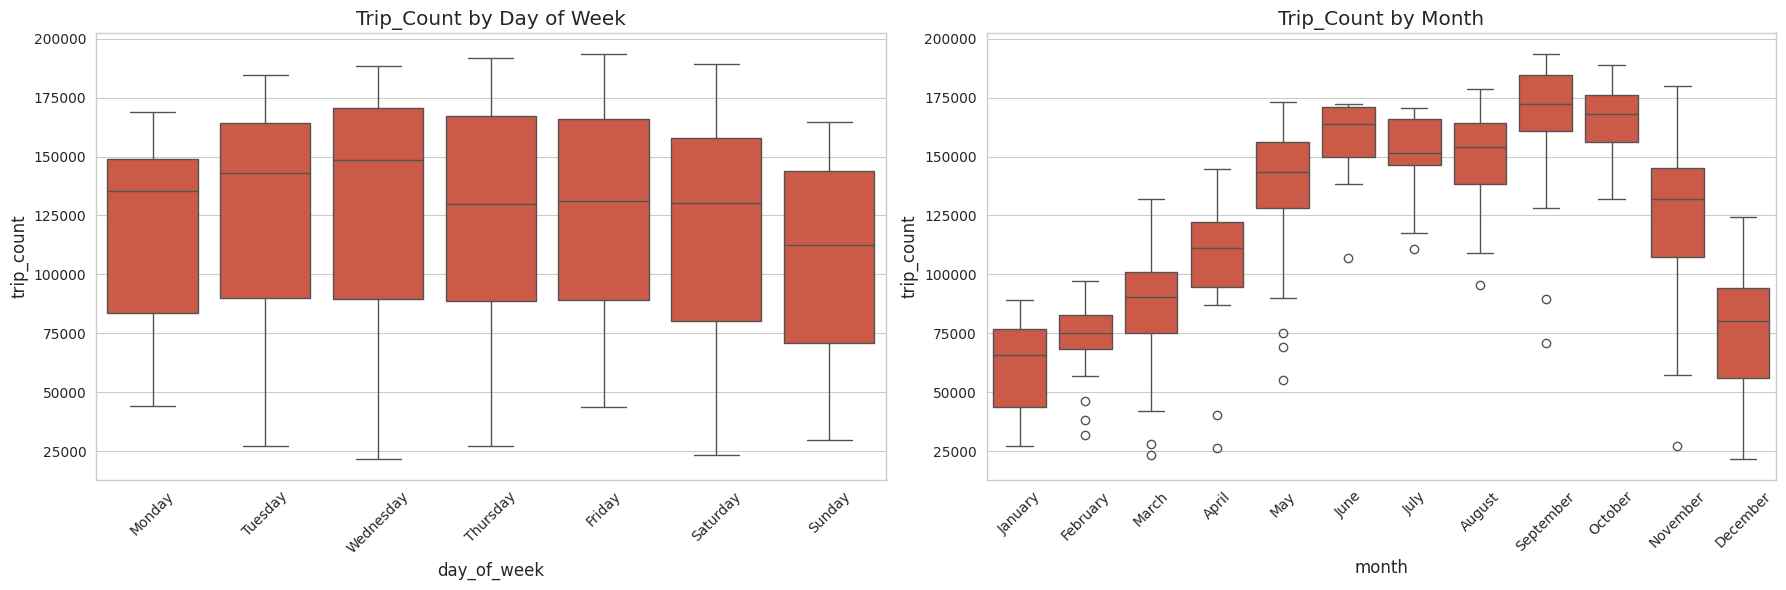

Interactive visualization saved to /content/drive/My Drive/capstone_project_25/output/citibike_interactive.html


In [ ]:
print("\nExploratory Data Analysis on Citi Bike:")
if citibike_data is not None and not citibike_data.empty:
    explore_time_series(
        citibike_data,
        'trip_count',
        'Daily Trip Count',
        'citibike',
        save_path=os.path.join(OUTPUT_PATH, 'daily_trip_count_citibike.png'))

    # Analyze day-of-week and monthly patterns
    analyze_temporal_patterns(citibike_data, 'trip_count')

    # Interactive plot
    fig = create_interactive_plot(citibike_data, 'trip_count', 'Daily Trip Count', 'citibike')
    fig.write_html(os.path.join(OUTPUT_PATH, 'citibike_interactive.html'))
    print(f"Interactive visualization saved to {os.path.join(OUTPUT_PATH, 'citibike_interactive.html')}")

# Part 5.3.2: EDA - Taxi Analysis


Exploratory Data Analysis on Taxi:
Figure saved to /content/drive/My Drive/capstone_project_25/output/daily_trip_count_taxi.png


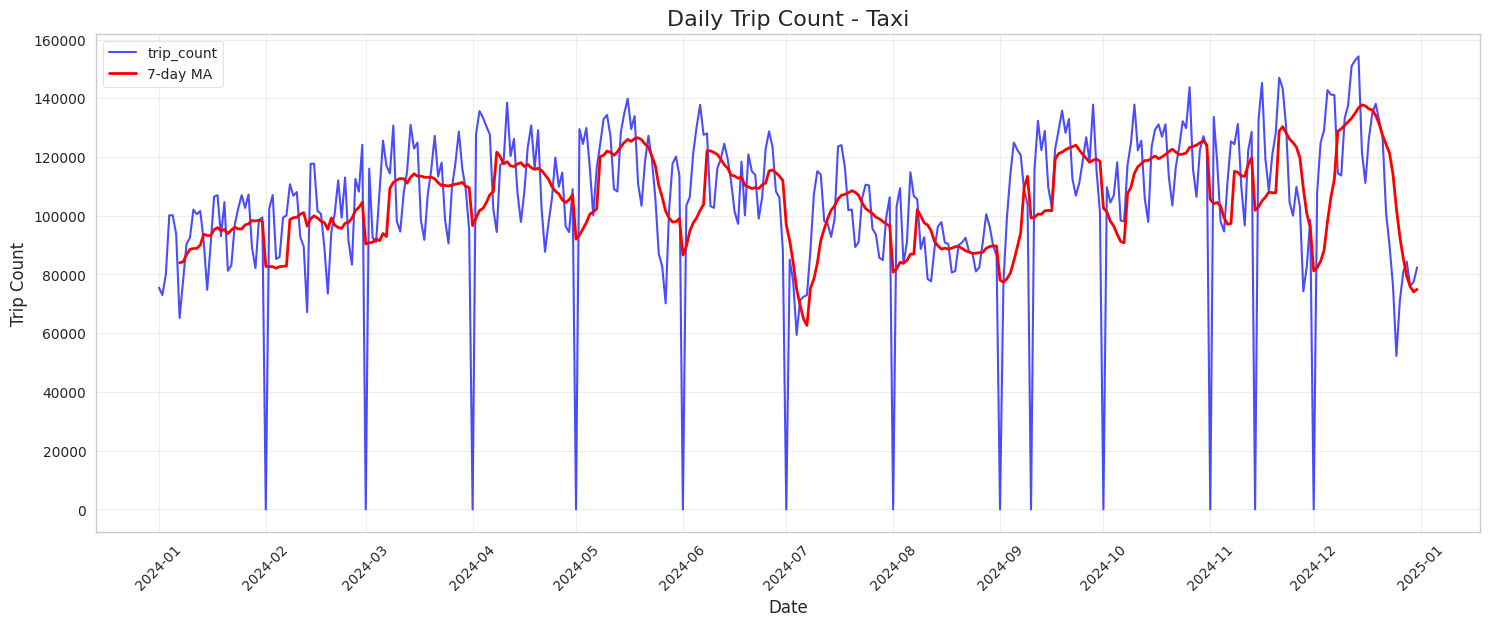

Descriptive statistics for trip_count:
count       366.000000
mean     104579.311475
std       26933.134551
min           1.000000
25%       93611.500000
50%      107298.000000
75%      122486.500000
max      154270.000000
Name: trip_count, dtype: float64


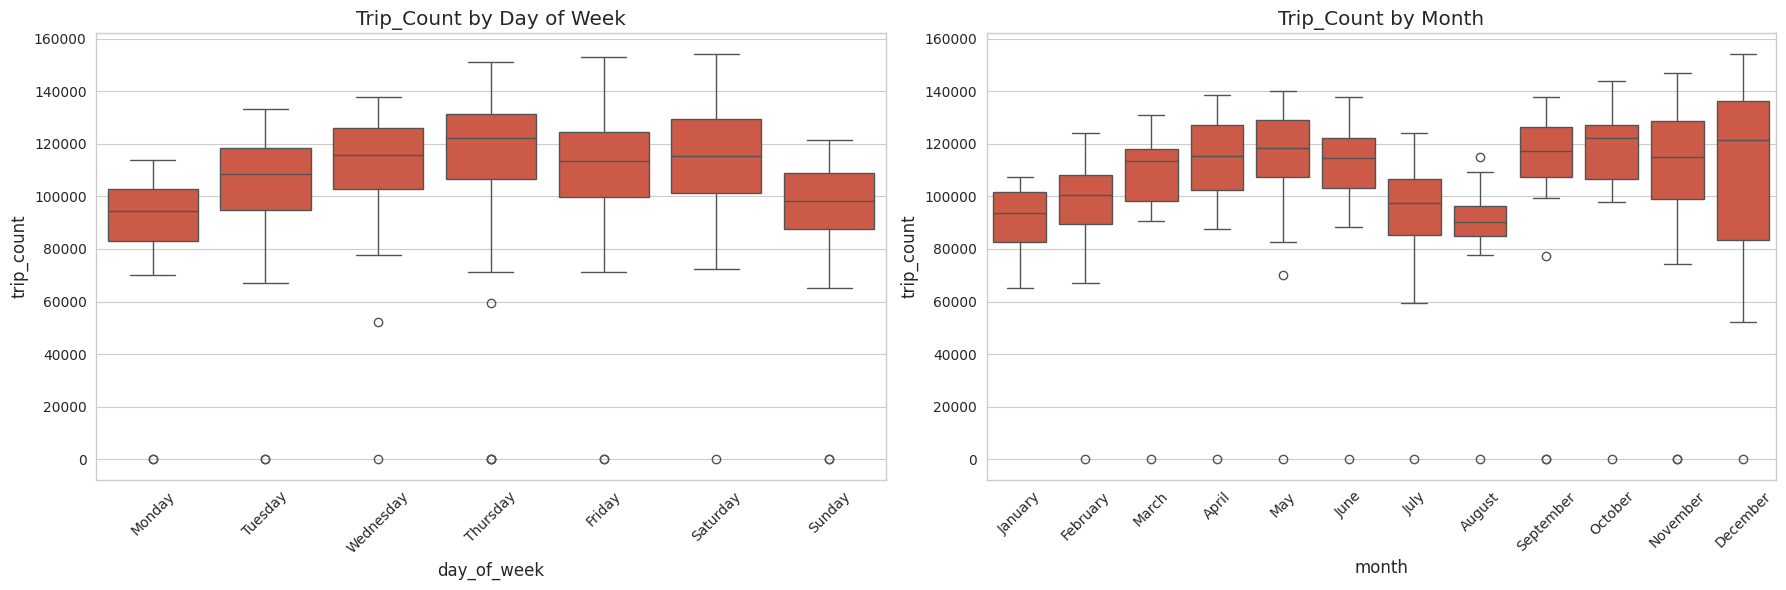

Interactive visualization saved to /content/drive/My Drive/capstone_project_25/output/taxi_interactive.html


In [ ]:
print("\nExploratory Data Analysis on Taxi:")
if taxi_data is not None and not taxi_data.empty:
    explore_time_series(
        taxi_data,
        'trip_count',
        'Daily Trip Count',
        'taxi',
        save_path=os.path.join(OUTPUT_PATH, 'daily_trip_count_taxi.png'))

    # Analyze day-of-week and monthly patterns
    analyze_temporal_patterns(taxi_data, 'trip_count')

    # Interactive plot for taxi
    taxi_fig = create_interactive_plot(taxi_data, 'trip_count', 'Daily Trip Count', 'taxi')
    taxi_fig.write_html(os.path.join(OUTPUT_PATH, 'taxi_interactive.html'))
    print(f"Interactive visualization saved to {os.path.join(OUTPUT_PATH, 'taxi_interactive.html')}")

# Part 5.3.3: EDA - Correlation Analysis


Correlation between Citi Bike and Taxi trip counts: 0.1174


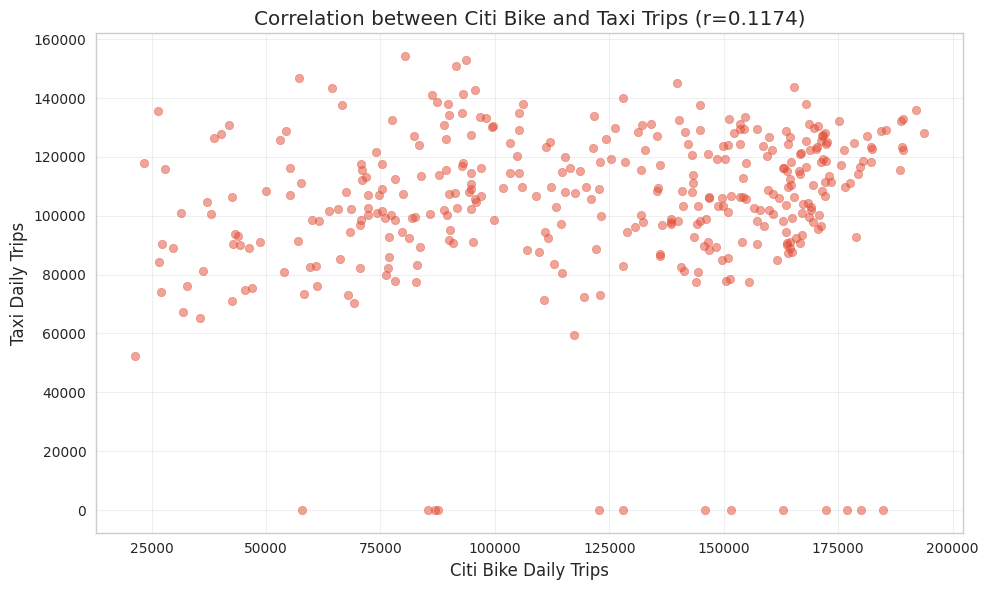

In [ ]:
# Create correlation analysis between the two datasets
if citibike_data is not None and taxi_data is not None:
    # Merge datasets on date
    merged_df = pd.merge(
        citibike_data[['date', 'trip_count']].rename(columns={'trip_count': 'citibike_trips'}),
        taxi_data[['date', 'trip_count']].rename(columns={'trip_count': 'taxi_trips'}),
        on='date', how='inner'
    )

    # Calculate correlation
    corr = merged_df['citibike_trips'].corr(merged_df['taxi_trips'])
    print(f"\nCorrelation between Citi Bike and Taxi trip counts: {corr:.4f}")

    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_df['citibike_trips'], merged_df['taxi_trips'], alpha=0.5)
    plt.title(f'Correlation between Citi Bike and Taxi Trips (r={corr:.4f})')
    plt.xlabel('Citi Bike Daily Trips')
    plt.ylabel('Taxi Daily Trips')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'bike_taxi_correlation.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Part 5.3.4: Forecasting - Setup

In [ ]:
target_col = 'trip_count'
print("\nTraining models...")

citibike_models = {}
taxi_models = {}

# Function to calculate accuracy metrics for all models
def calculate_model_metrics(actual_data, models_dict, target_column):
    """Calculate and return metrics for all models in the dictionary."""
    results = {}
    for model_name, (model, predictions) in models_dict.items():
        if model is None or predictions is None:
            print(f"Skipping {model_name} - model or predictions are None")
            continue

        if model_name == 'prophet':
            if 'yhat' not in predictions.columns:
                print(f"Skipping {model_name} - 'yhat' not in predictions")
                continue

            if len(predictions) != len(actual_data):
                print(f"Warning: {model_name} predictions length mismatch")
                # Try to match by date
                merged = pd.merge(
                    actual_data[['date', target_column]],
                    predictions[['ds', 'yhat']],
                    left_on='date',
                    right_on='ds',
                    how='inner'
                )
                if merged.empty:
                    print(f"Cannot evaluate {model_name} - no matching dates")
                    continue

                metrics = evaluate_forecast(merged[target_column], merged['yhat'])
            else:
                metrics = evaluate_forecast(actual_data[target_column], predictions['yhat'])

        elif model_name == 'arima':
            if len(predictions) != len(actual_data):
                print(f"Warning: {model_name} predictions length mismatch")
                continue

            metrics = evaluate_forecast(actual_data[target_column], predictions)

        results[model_name] = metrics

    return results


Training models...


# Part 5.3.4: Forecasting - Citi Bike Models


Citi Bike ARIMA:
ARIMA Evaluation:
MSE: 432048208.4957
RMSE: 20785.7694
MAE: 14828.9744
R^2: 0.7816
Figure saved to /content/drive/My Drive/capstone_project_25/output/arima_vs_actual.png


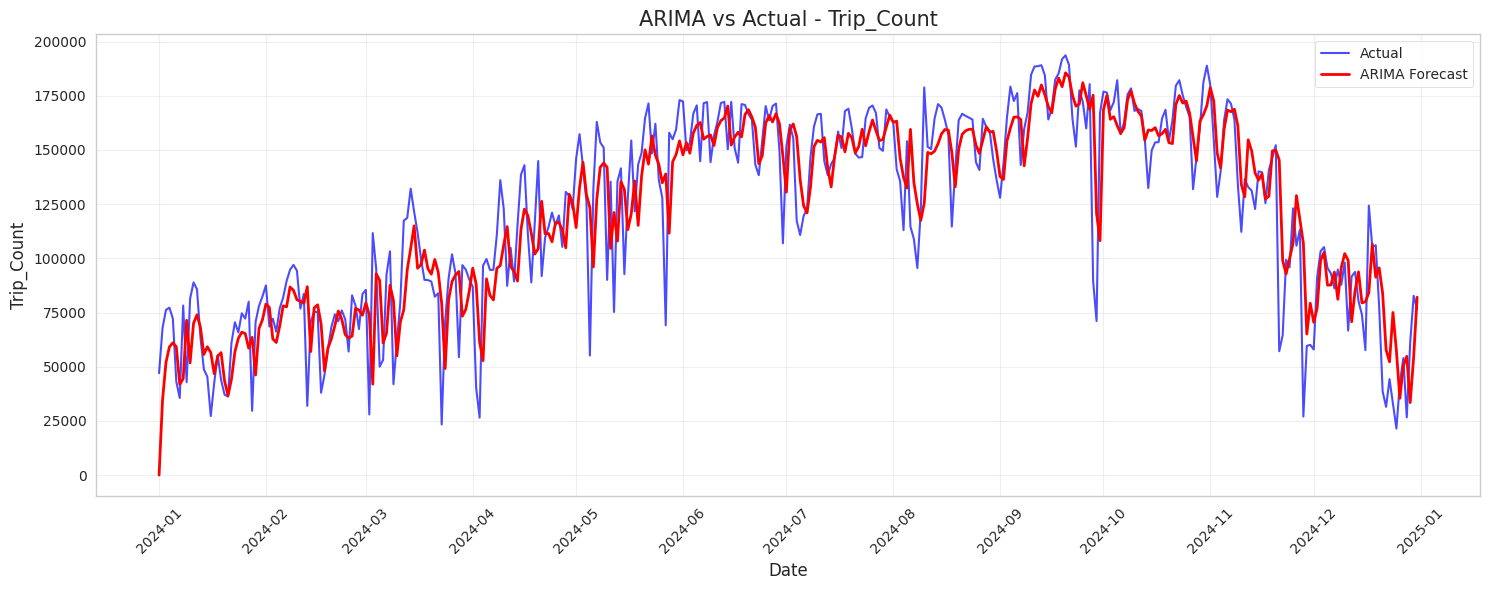

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6hzry1qh/27utdl0e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6hzry1qh/_6u80vop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51926', 'data', 'file=/tmp/tmp6hzry1qh/27utdl0e.json', 'init=/tmp/tmp6hzry1qh/_6u80vop.json', 'output', 'file=/tmp/tmp6hzry1qh/prophet_modelc88l6hoz/prophet_model-20250407024336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:43:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:43:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Citi Bike Prophet:
Prophet Evaluation (direct):
MSE: 344536659.1288
RMSE: 18561.6987
MAE: 13811.0950
R^2: 0.8258
Figure saved to /content/drive/My Drive/capstone_project_25/output/prophet_vs_actual.png


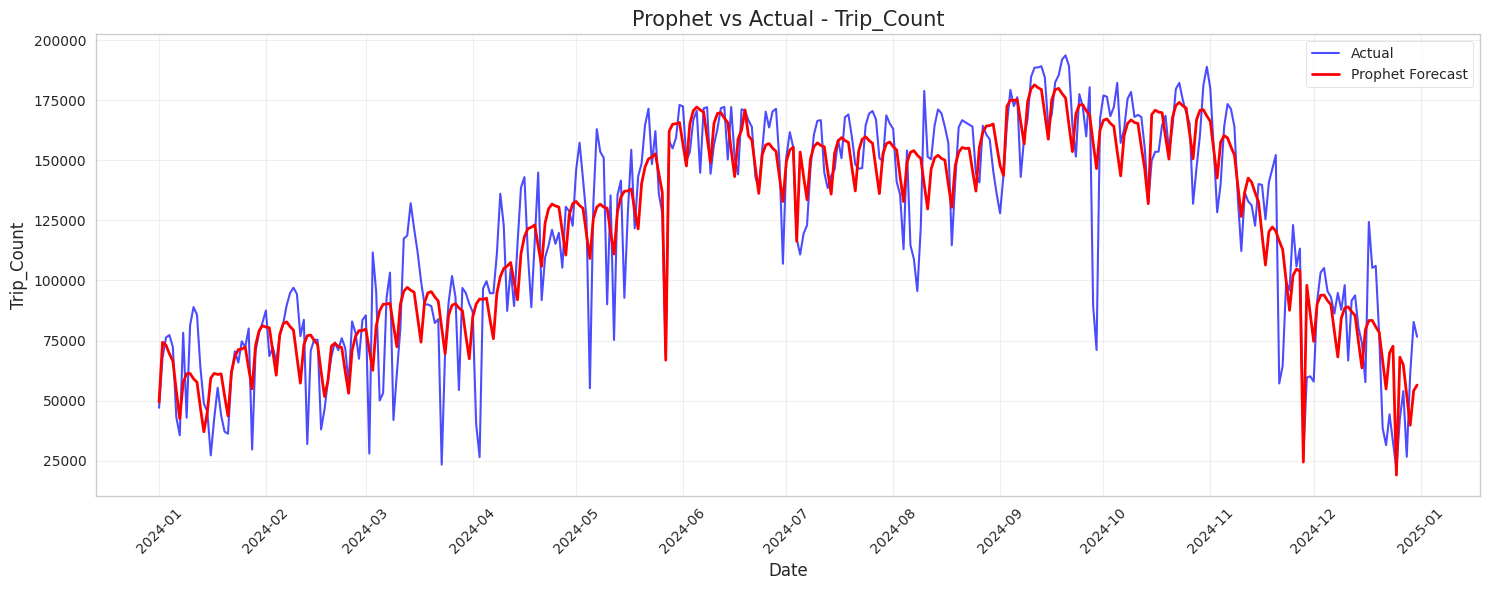

<Figure size 1500x1000 with 0 Axes>

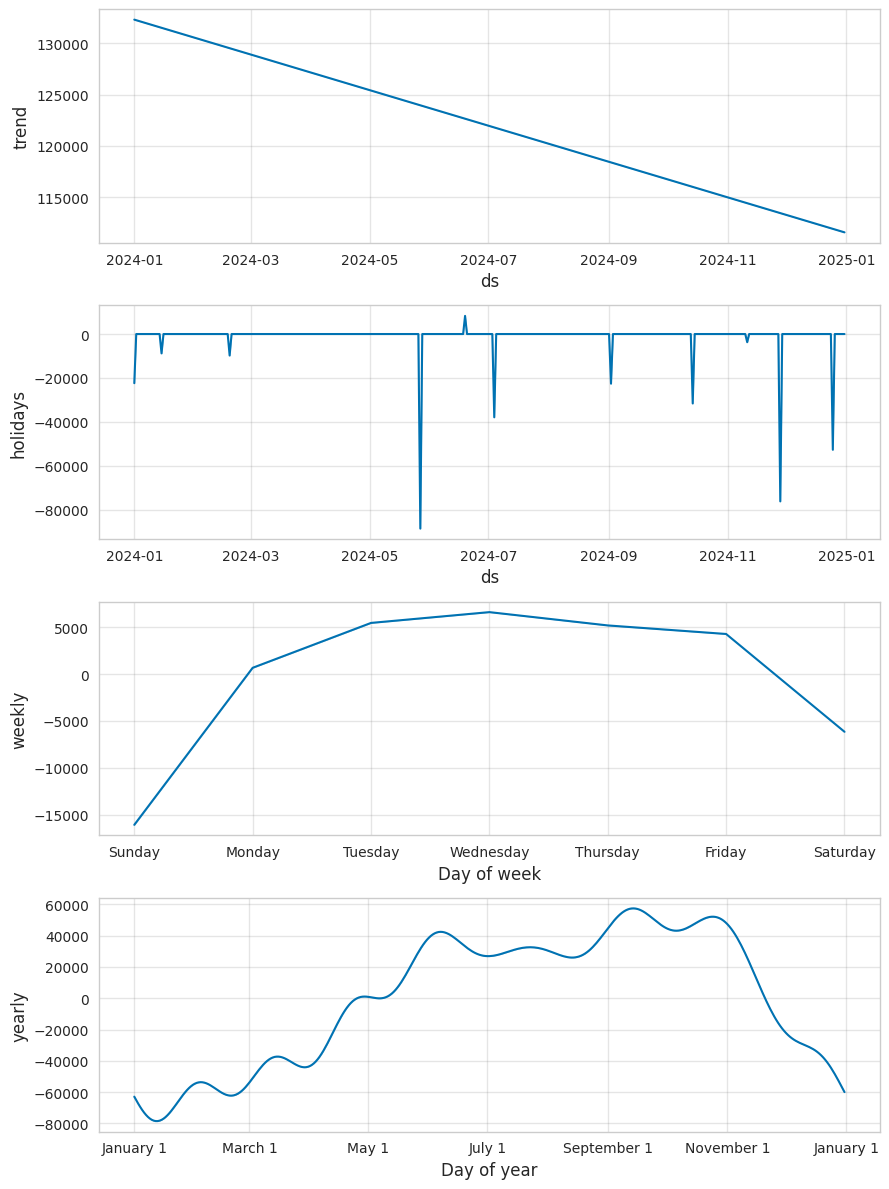

In [ ]:
# ARIMA & Prophet for Citi Bike
if citibike_data is not None and not citibike_data.empty:
    print("\nCiti Bike ARIMA:")
    arima_model, arima_preds = train_arima_model(citibike_data, target_col)
    if arima_model and arima_preds is not None:
        citibike_models['arima'] = (arima_model, arima_preds)
        print("ARIMA Evaluation:")
        evaluate_forecast(citibike_data[target_col].values, arima_preds)
        plot_forecast_results(
            citibike_data['date'],
            citibike_data[target_col].values,
            arima_preds,
            'ARIMA',
            target_col,
            save_path=os.path.join(OUTPUT_PATH, 'arima_vs_actual.png')
        )

    print("\nCiti Bike Prophet:")
    prophet_model, prophet_forecast = train_prophet_model(citibike_data, target_col)
    if prophet_model and prophet_forecast is not None:
        citibike_models['prophet'] = (prophet_model, prophet_forecast)
        if 'yhat' in prophet_forecast.columns:
            # Ensure matching length
            if len(prophet_forecast) == len(citibike_data):
                print("Prophet Evaluation (direct):")
                evaluate_forecast(citibike_data[target_col].values, prophet_forecast['yhat'].values)
                plot_forecast_results(
                    citibike_data['date'],
                    citibike_data[target_col].values,
                    prophet_forecast['yhat'].values,
                    'Prophet',
                    target_col,
                    save_path=os.path.join(OUTPUT_PATH, 'prophet_vs_actual.png')
                )
            else:
                # Merge approach
                eval_df = pd.merge(
                    citibike_data[['date',target_col]],
                    prophet_forecast[['date','yhat']],
                    on='date', how='inner'
                ).dropna(subset=['yhat'])
                print("Prophet Evaluation (merged):")
                evaluate_forecast(eval_df[target_col].values, eval_df['yhat'].values)
                plot_forecast_results(
                    eval_df['date'],
                    eval_df[target_col].values,
                    eval_df['yhat'].values,
                    'Prophet',
                    target_col,
                    save_path=os.path.join(OUTPUT_PATH, 'prophet_vs_actual.png')
                )

        # Visualize Prophet components - with error handling
        if prophet_model:
            try:
                plt.figure(figsize=(15, 10))
                # Create future dataframe explicitly with all components
                future = prophet_model.make_future_dataframe(periods=0)
                forecast = prophet_model.predict(future)

                # Check if all required components exist before plotting
                required_components = ['trend', 'weekly', 'yearly', 'holidays']
                missing_components = [c for c in required_components if c not in forecast.columns]

                if missing_components:
                    print(f"Warning: Cannot plot components. Missing: {missing_components}")
                    print("Available components:", [c for c in forecast.columns if c not in ['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

                    # Create separate plots for available components as an alternative
                    plt.figure(figsize=(15, 10))
                    for i, comp in enumerate([c for c in forecast.columns if c not in ['ds', 'yhat', 'yhat_lower', 'yhat_upper']]):
                        plt.subplot(len(forecast.columns)-4, 1, i+1)
                        plt.plot(forecast['ds'], forecast[comp])
                        plt.title(f'Component: {comp}')
                    plt.tight_layout()
                else:
                    # Standard Prophet component plot if all components are available
                    prophet_model.plot_components(forecast)
                    plt.tight_layout()

                plt.savefig(os.path.join(OUTPUT_PATH, 'prophet_components_citibike.png'), dpi=300, bbox_inches='tight')
                plt.show()
            except Exception as e:
                print(f"Error plotting Prophet components: {e}")
                print("Continuing with analysis...")

# Part 5.3.4: Forecasting - Taxi Models


Taxi ARIMA:
ARIMA Evaluation (Taxi):
MSE: 641338153.9878
RMSE: 25324.6551
MAE: 16584.9311
R^2: 0.1135
Figure saved to /content/drive/My Drive/capstone_project_25/output/arima_vs_actual_taxi.png


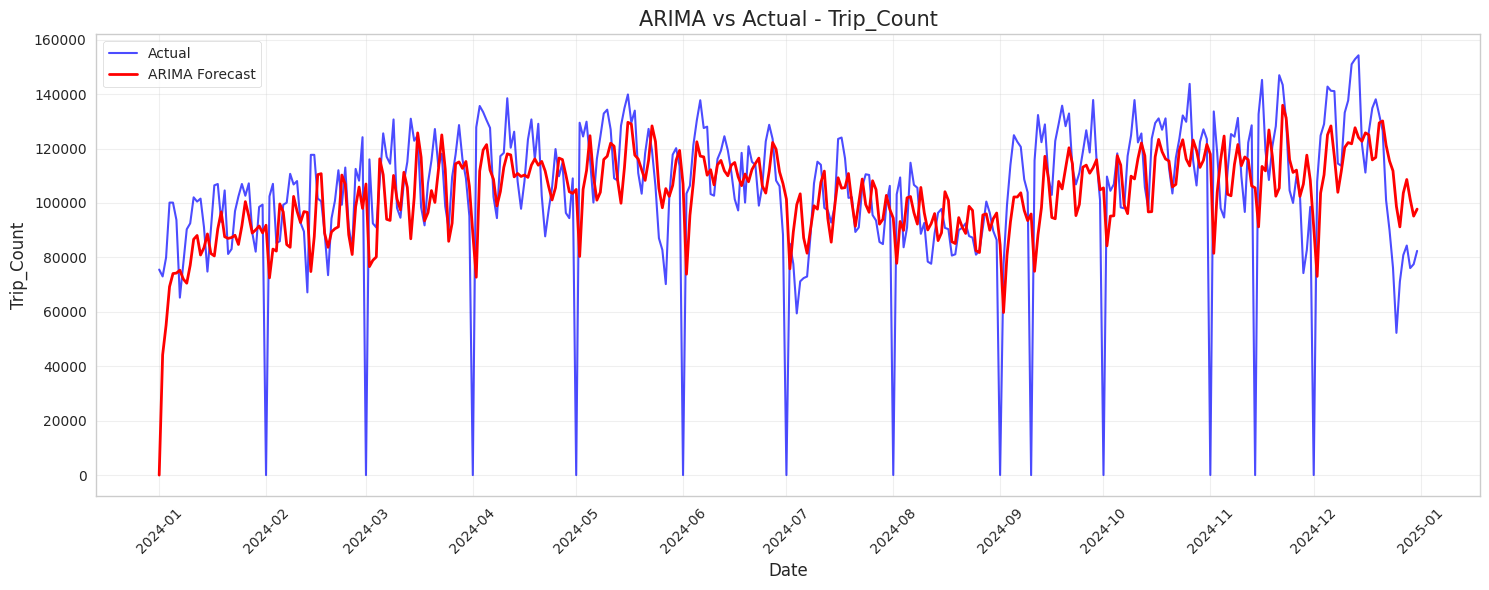


Taxi Prophet:


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6hzry1qh/kskot82s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6hzry1qh/um8nj0ka.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99856', 'data', 'file=/tmp/tmp6hzry1qh/kskot82s.json', 'init=/tmp/tmp6hzry1qh/um8nj0ka.json', 'output', 'file=/tmp/tmp6hzry1qh/prophet_modelsybxvl90/prophet_model-20250407024654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:46:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:46:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Evaluation (Taxi direct):
MSE: 512957123.4293
RMSE: 22648.5568
MAE: 11562.9597
R^2: 0.2909
Figure saved to /content/drive/My Drive/capstone_project_25/output/prophet_vs_actual_taxi.png


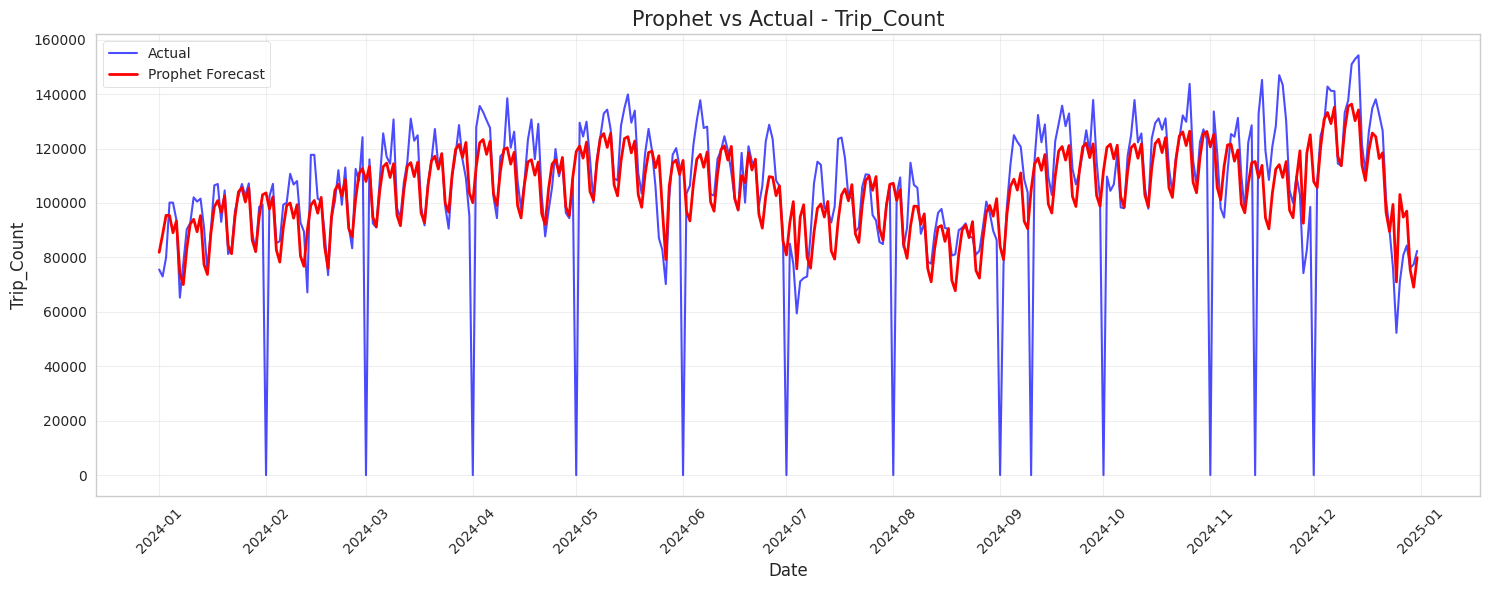

<Figure size 1500x1000 with 0 Axes>

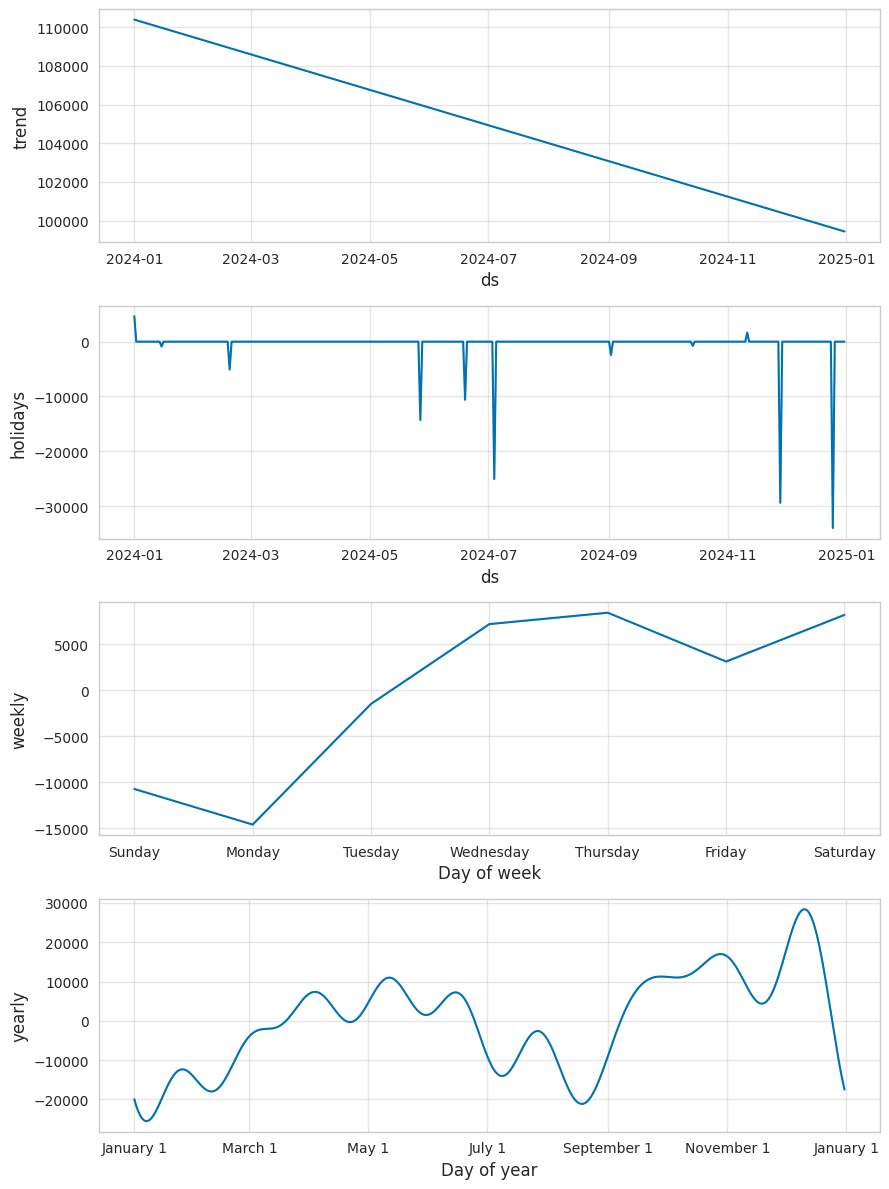

In [ ]:
# ARIMA & Prophet for Taxi
if taxi_data is not None and not taxi_data.empty:
    print("\nTaxi ARIMA:")
    arima_model, arima_preds = train_arima_model(taxi_data, target_col)
    if arima_model and arima_preds is not None:
        taxi_models['arima'] = (arima_model, arima_preds)
        print("ARIMA Evaluation (Taxi):")
        evaluate_forecast(taxi_data[target_col].values, arima_preds)
        plot_forecast_results(
            taxi_data['date'],
            taxi_data[target_col].values,
            arima_preds,
            'ARIMA',
            target_col,
            save_path=os.path.join(OUTPUT_PATH, 'arima_vs_actual_taxi.png')
        )

    print("\nTaxi Prophet:")
    prophet_model, prophet_forecast = train_prophet_model(taxi_data, target_col)
    if prophet_model and prophet_forecast is not None:
        taxi_models['prophet'] = (prophet_model, prophet_forecast)
        if 'yhat' in prophet_forecast.columns:
            if len(prophet_forecast) == len(taxi_data):
                print("Prophet Evaluation (Taxi direct):")
                evaluate_forecast(taxi_data[target_col].values, prophet_forecast['yhat'].values)
                plot_forecast_results(
                    taxi_data['date'],
                    taxi_data[target_col].values,
                    prophet_forecast['yhat'].values,
                    'Prophet',
                    target_col,
                    save_path=os.path.join(OUTPUT_PATH, 'prophet_vs_actual_taxi.png')
                )
            else:
                eval_df = pd.merge(
                    taxi_data[['date',target_col]],
                    prophet_forecast[['date','yhat']],
                    on='date', how='inner'
                ).dropna(subset=['yhat'])
                print("Prophet Evaluation (Taxi merged):")
                evaluate_forecast(eval_df[target_col].values, eval_df['yhat'].values)
                plot_forecast_results(
                    eval_df['date'],
                    eval_df[target_col].values,
                    eval_df['yhat'].values,
                    'Prophet',
                    target_col,
                    save_path=os.path.join(OUTPUT_PATH, 'prophet_vs_actual_taxi.png')
                )

        # Visualize Prophet components for taxi - with error handling
        if prophet_model:
            try:
                plt.figure(figsize=(15, 10))
                # Create future dataframe explicitly with all components
                future = prophet_model.make_future_dataframe(periods=0)
                forecast = prophet_model.predict(future)

                # Check if all required components exist before plotting
                required_components = ['trend', 'weekly', 'yearly', 'holidays']
                missing_components = [c for c in required_components if c not in forecast.columns]

                if missing_components:
                    print(f"Warning: Cannot plot all components. Missing: {missing_components}")
                    print("Available components:", [c for c in forecast.columns if c not in ['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

                    # Create separate plots for available components as an alternative
                    available_comps = [c for c in forecast.columns if c not in ['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
                    if available_comps:
                        fig, axes = plt.subplots(len(available_comps), 1, figsize=(15, 4*len(available_comps)))
                        if len(available_comps) == 1:
                            axes = [axes]  # Make it iterable if there's only one component

                        for i, comp in enumerate(available_comps):
                            axes[i].plot(forecast['ds'], forecast[comp])
                            axes[i].set_title(f'Component: {comp}')
                            axes[i].set_xlabel('Date')
                            axes[i].set_ylabel(comp)
                        plt.tight_layout()
                    else:
                        print("No components available for plotting")
                else:
                    # Standard Prophet component plot if all components are available
                    prophet_model.plot_components(forecast)
                    plt.tight_layout()

                plt.savefig(os.path.join(OUTPUT_PATH, 'prophet_components_taxi.png'), dpi=300, bbox_inches='tight')
                plt.show()
            except Exception as e:
                print(f"Error plotting Prophet components: {e}")
                print("Continuing with analysis...")

# Part 5.3.4: Forecasting - Model Comparison


=== Model Performance Comparison ===

Citi Bike Model Metrics:
MSE: 432048208.4957
RMSE: 20785.7694
MAE: 14828.9744
R^2: 0.7816
MSE: 344536659.1288
RMSE: 18561.6987
MAE: 13811.0950
R^2: 0.8258
                  mse        rmse         mae      r2
arima    4.320482e+08  20785.7694  14828.9744  0.7816
prophet  3.445367e+08  18561.6987  13811.0950  0.8258


<Figure size 1200x600 with 0 Axes>

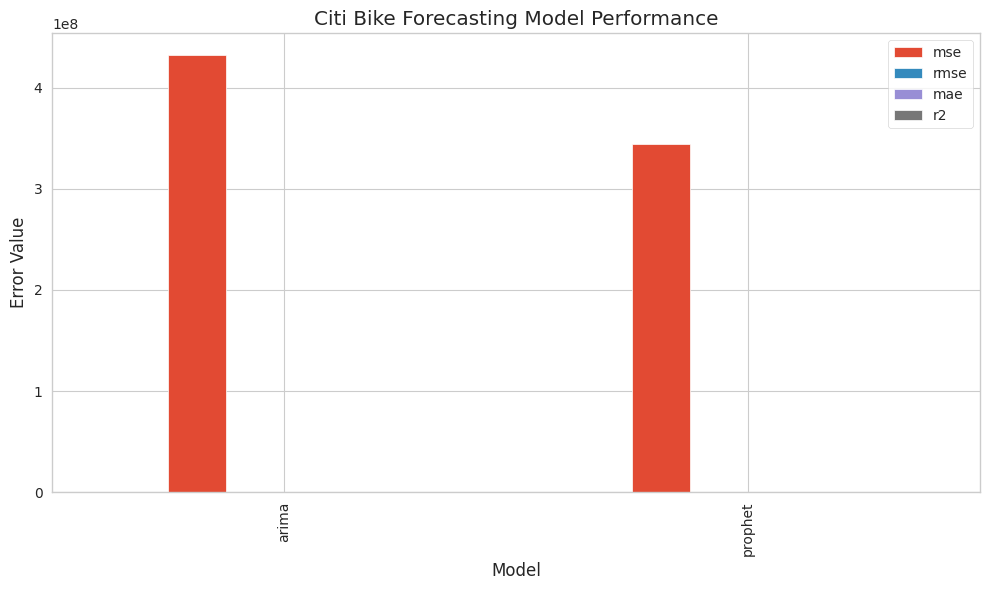


Taxi Model Metrics:
MSE: 641338153.9878
RMSE: 25324.6551
MAE: 16584.9311
R^2: 0.1135
MSE: 512957123.4293
RMSE: 22648.5568
MAE: 11562.9597
R^2: 0.2909
                  mse        rmse         mae      r2
arima    6.413382e+08  25324.6551  16584.9311  0.1135
prophet  5.129571e+08  22648.5568  11562.9597  0.2909


<Figure size 1200x600 with 0 Axes>

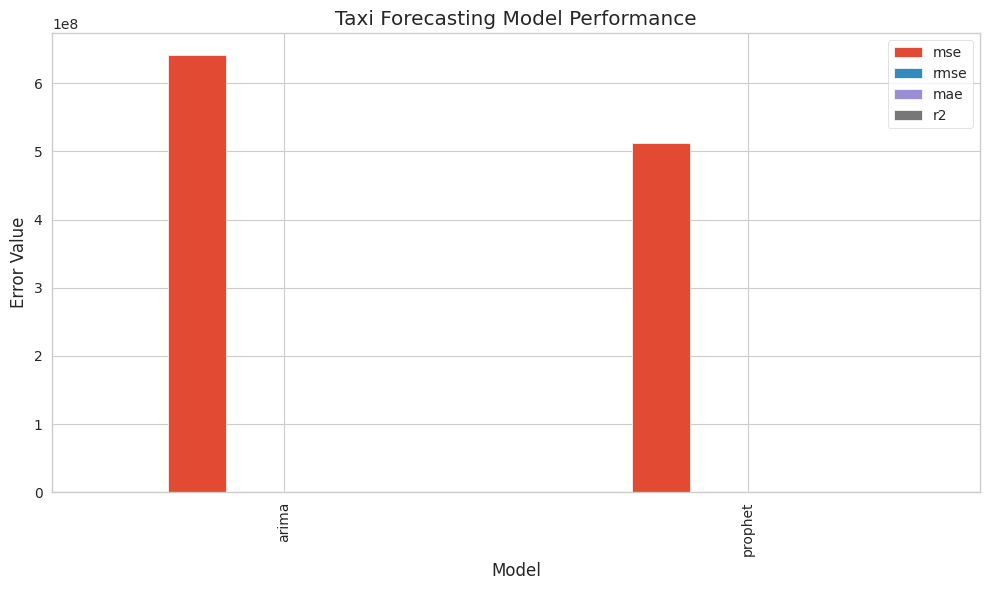

In [ ]:
# Compare model performance metrics
print("\n=== Model Performance Comparison ===")

print("\nCiti Bike Model Metrics:")
citibike_metrics = calculate_model_metrics(citibike_data, citibike_models, target_col)
if citibike_metrics:
    metrics_df = pd.DataFrame.from_dict(citibike_metrics, orient='index')
    print(metrics_df.round(4))

    # Save metrics to CSV
    metrics_df.to_csv(os.path.join(OUTPUT_PATH, 'citibike_model_metrics.csv'))

    # Create bar chart of metrics
    plt.figure(figsize=(12, 6))
    metrics_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Citi Bike Forecasting Model Performance')
    plt.ylabel('Error Value')
    plt.xlabel('Model')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'citibike_model_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

print("\nTaxi Model Metrics:")
taxi_metrics = calculate_model_metrics(taxi_data, taxi_models, target_col)
if taxi_metrics:
    metrics_df = pd.DataFrame.from_dict(taxi_metrics, orient='index')
    print(metrics_df.round(4))

    # Save metrics to CSV
    metrics_df.to_csv(os.path.join(OUTPUT_PATH, 'taxi_model_metrics.csv'))

    # Create bar chart of metrics
    plt.figure(figsize=(12, 6))
    metrics_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Taxi Forecasting Model Performance')
    plt.ylabel('Error Value')
    plt.xlabel('Model')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'taxi_model_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Part 5.3.5: Anomaly Detection - Updated Functions

In [ ]:
def detect_anomalies_stl(df, target_col, period=7, threshold=2.0):
    """STL-based anomaly detection with improved error handling."""
    if df is None or df.empty:
        return None, None, None

    ts_data = df.set_index('date')[target_col].sort_index()

    # Check if we have enough data points
    if len(ts_data) < 2 * period:
        print(f"Warning: Not enough data points for STL decomposition (need at least {2 * period}, have {len(ts_data)})")
        return None, None, None

    try:
        # Try with explicit period
        stl_result = seasonal_decompose(ts_data, period=period)

        # Check if any components are missing
        if not hasattr(stl_result, 'trend') or stl_result.trend is None:
            print("Warning: STL decomposition failed to extract trend component")
            return None, None, None

        resid = stl_result.resid.dropna()

        # Check if we have enough residuals
        if len(resid) < 10:
            print("Warning: Too few residuals after STL decomposition")
            return None, None, None

        mean_resid = resid.mean()
        std_resid = resid.std()

        # Avoid division by zero
        if std_resid == 0:
            print("Warning: Standard deviation of residuals is zero")
            return None, None, None

        z_scores = (resid - mean_resid) / std_resid
        anomalies = abs(z_scores) > threshold
        return anomalies, z_scores, stl_result

    except Exception as e:
        print(f"Error in STL decomposition: {e}")
        print("Falling back to simple residual-based detection...")

        # Simple alternative: use moving average
        ma = ts_data.rolling(window=period).mean()
        resid = ts_data - ma
        resid = resid.dropna()

        if len(resid) < 10:
            return None, None, None

        mean_resid = resid.mean()
        std_resid = resid.std()

        if std_resid == 0:
            return None, None, None

        z_scores = (resid - mean_resid) / std_resid
        anomalies = abs(z_scores) > threshold
        return anomalies, z_scores, None

def ensemble_anomaly_detection(df, target_col, models=None, methods=None, threshold=2.0):
    """Combine multiple anomaly detection methods with improved error handling."""
    if df is None or df.empty:
        return None

    if methods is None:
        methods = ['residual', 'iqr']  # Default to more reliable methods
        if len(df) >= 30:  # Only use STL if we have enough data
            methods.append('stl')

    # Sort by date, create new df
    results = df.sort_values('date').reset_index(drop=True)
    anomaly_flags = np.zeros(len(results), dtype=bool)

    # 1) Residual-based
    if 'residual' in methods and models is not None:
        for model_name, (model, preds) in models.items():
            if model_name == 'prophet' and preds is not None:
                # preds is a df
                if len(preds) == len(results) and 'yhat' in preds.columns:
                    try:
                        anomalies, _ = detect_anomalies_residual(results[target_col].values, preds['yhat'].values, threshold)
                        results[f'{model_name}_anomaly'] = anomalies
                        anomaly_flags = anomaly_flags | anomalies
                    except Exception as e:
                        print(f"Error in {model_name} residual detection: {e}")
                else:
                    print(f"[Warning] Prophet predictions length mismatch or missing 'yhat' column")
            elif model_name == 'arima' and preds is not None:
                if len(preds) == len(results):
                    try:
                        anomalies, _ = detect_anomalies_residual(results[target_col].values, preds.values, threshold)
                        results[f'{model_name}_anomaly'] = anomalies
                        anomaly_flags = anomaly_flags | anomalies
                    except Exception as e:
                        print(f"Error in {model_name} residual detection: {e}")
                else:
                    print(f"[Warning] ARIMA predictions length mismatch")

    # 2) STL-based
    if 'stl' in methods:
        anom_stl, _, _ = detect_anomalies_stl(results, target_col, period=7, threshold=threshold)
        if anom_stl is not None:
            # Convert anom_stl (DatetimeIndex) -> boolean array
            date_index = pd.to_datetime(results['date'])
            stl_mask = np.zeros(len(results), dtype=bool)
            for dt_idx, val in anom_stl.items():
                if val:
                    # find matching row
                    match = np.where(date_index == dt_idx)[0]
                    if len(match) > 0:
                        stl_mask[match[0]] = True
            results['stl_anomaly'] = stl_mask
            anomaly_flags = anomaly_flags | stl_mask
        else:
            print("STL anomaly detection failed, skipping this method")

    # 3) IQR-based (this is quite robust)
    if 'iqr' in methods:
        try:
            Q1 = results[target_col].quantile(0.25)
            Q3 = results[target_col].quantile(0.75)
            IQR = Q3 - Q1
            if IQR > 0:  # Avoid issues with constant data
                iqr_anomalies = (results[target_col] < (Q1 - 1.5 * IQR)) | (results[target_col] > (Q3 + 1.5 * IQR))
                results['iqr_anomaly'] = iqr_anomalies
                anomaly_flags = anomaly_flags | iqr_anomalies
        except Exception as e:
            print(f"Error in IQR-based detection: {e}")

    results['is_anomaly'] = anomaly_flags
    return results

# Part 5.3.5: Anomaly Detection - Citi Bike


Anomaly Detection...
Detecting anomalies in Citi Bike data...
Found 16 anomalies in Citi Bike.
Figure saved to /content/drive/My Drive/capstone_project_25/output/citibike_anomalies.png


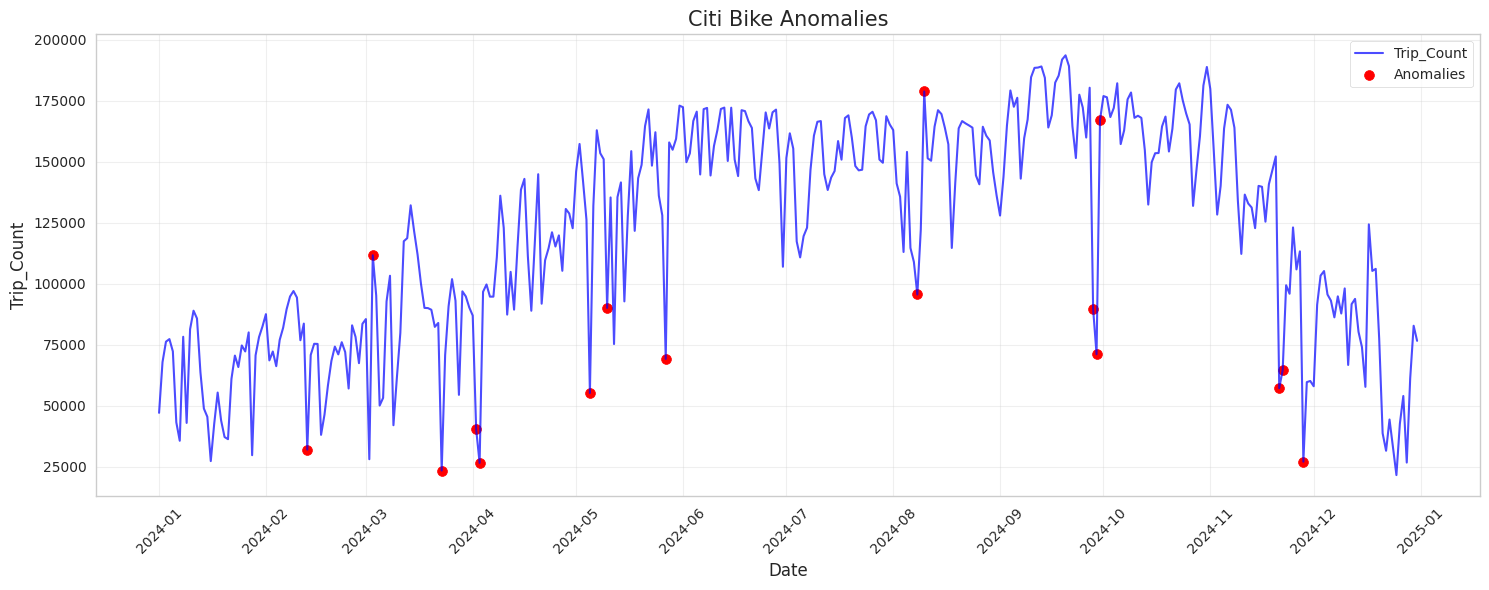

Saved Citi Bike anomalies to /content/drive/My Drive/capstone_project_25/output/citibike_anomalies.csv

Citi Bike Anomalies:


,date,day_name,trip_count,is_anomaly
43,2024-02-13,Tuesday,31930,True
62,2024-03-03,Sunday,111658,True
82,2024-03-23,Saturday,23351,True
92,2024-04-02,Tuesday,40239,True
93,2024-04-03,Wednesday,26487,True
125,2024-05-05,Sunday,55165,True
130,2024-05-10,Friday,90071,True
147,2024-05-27,Monday,69139,True
220,2024-08-08,Thursday,95573,True
222,2024-08-10,Saturday,178856,True


In [ ]:
print("\nAnomaly Detection...")

# Citi Bike
cb_anomalies = None  # Define empty variable in case of failure

if citibike_data is not None and not citibike_data.empty and citibike_models:
    print("Detecting anomalies in Citi Bike data...")
    try:
        cb_anomalies = ensemble_anomaly_detection(
            citibike_data,
            target_col=target_col,
            models=citibike_models,
            methods=['residual', 'iqr'],  # Start with more reliable methods
            threshold=2.5
        )
        if cb_anomalies is not None and cb_anomalies['is_anomaly'].sum() > 0:
            print(f"Found {cb_anomalies['is_anomaly'].sum()} anomalies in Citi Bike.")
            plot_anomalies(
                cb_anomalies['date'],
                cb_anomalies[target_col],
                cb_anomalies['is_anomaly'],
                'Citi Bike Anomalies',
                target_col,
                save_path=os.path.join(OUTPUT_PATH, 'citibike_anomalies.png')
            )

            # Save anomalies to CSV
            cb_anomalies_only = cb_anomalies[cb_anomalies['is_anomaly']].copy()
            cb_anomalies_only.to_csv(os.path.join(OUTPUT_PATH, 'citibike_anomalies.csv'), index=False)
            print(f"Saved Citi Bike anomalies to {os.path.join(OUTPUT_PATH, 'citibike_anomalies.csv')}")

            # Display anomalies
            print("\nCiti Bike Anomalies:")
            display(cb_anomalies_only[['date', 'day_name', target_col, 'is_anomaly']].sort_values('date'))
        else:
            print("No anomalies found in Citi Bike data.")
    except Exception as e:
        print(f"Error during Citi Bike anomaly detection: {e}")
        cb_anomalies = None

# Part 5.3.5: Anomaly Detection - Taxi

Detecting anomalies in Taxi data...
Found 14 anomalies in Taxi.
Figure saved to /content/drive/My Drive/capstone_project_25/output/taxi_anomalies.png


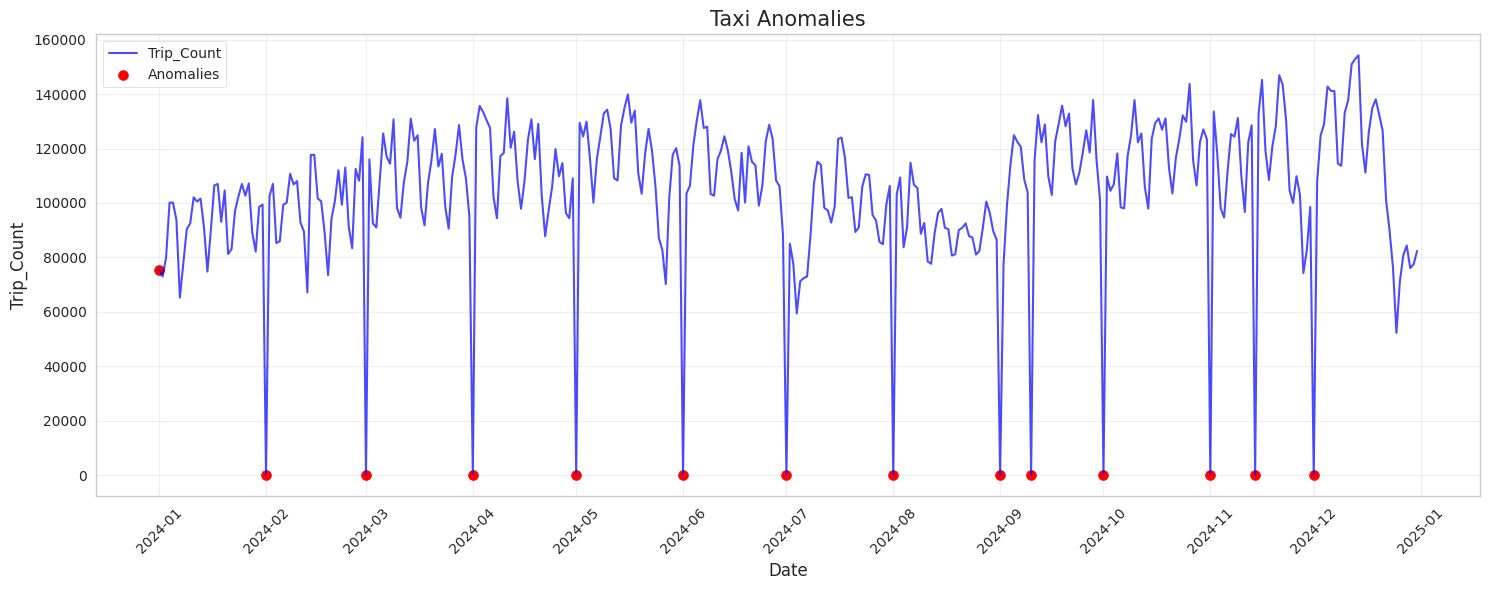

Saved Taxi anomalies to /content/drive/My Drive/capstone_project_25/output/taxi_anomalies.csv

Taxi Anomalies:


,date,day_name,trip_count,is_anomaly
0,2024-01-01,Monday,75529,True
31,2024-02-01,Thursday,3,True
60,2024-03-01,Friday,2,True
91,2024-04-01,Monday,2,True
121,2024-05-01,Wednesday,1,True
152,2024-06-01,Saturday,12,True
182,2024-07-01,Monday,3,True
213,2024-08-01,Thursday,29,True
244,2024-09-01,Sunday,30,True
253,2024-09-10,Tuesday,2,True


In [ ]:
# Taxi
taxi_anoms = None  # empty variable in case of failure

if taxi_data is not None and not taxi_data.empty and taxi_models:
    print("Detecting anomalies in Taxi data...")
    try:
        taxi_anoms = ensemble_anomaly_detection(
            taxi_data,
            target_col=target_col,
            models=taxi_models,
            methods=['residual', 'iqr'],  # Start with more reliable methods
            threshold=2.5
        )
        if taxi_anoms is not None and taxi_anoms['is_anomaly'].sum() > 0:
            print(f"Found {taxi_anoms['is_anomaly'].sum()} anomalies in Taxi.")
            plot_anomalies(
                taxi_anoms['date'],
                taxi_anoms[target_col],
                taxi_anoms['is_anomaly'],
                'Taxi Anomalies',
                target_col,
                save_path=os.path.join(OUTPUT_PATH, 'taxi_anomalies.png')
            )

            # Save anomalies to CSV
            taxi_anoms_only = taxi_anoms[taxi_anoms['is_anomaly']].copy()
            taxi_anoms_only.to_csv(os.path.join(OUTPUT_PATH, 'taxi_anomalies.csv'), index=False)
            print(f"Saved Taxi anomalies to {os.path.join(OUTPUT_PATH, 'taxi_anomalies.csv')}")

            # Display anomalies
            print("\nTaxi Anomalies:")
            display(taxi_anoms_only[['date', 'day_name', target_col, 'is_anomaly']].sort_values('date'))
        else:
            print("No anomalies found in Taxi data.")
    except Exception as e:
        print(f"Error during Taxi anomaly detection: {e}")
        taxi_anoms = None

# Part 5.3.5: Anomaly Detection - Dashboard & Analysis


Creating dashboard...
Dashboard saved to /content/drive/My Drive/capstone_project_25/output/anomaly_dashboard.html


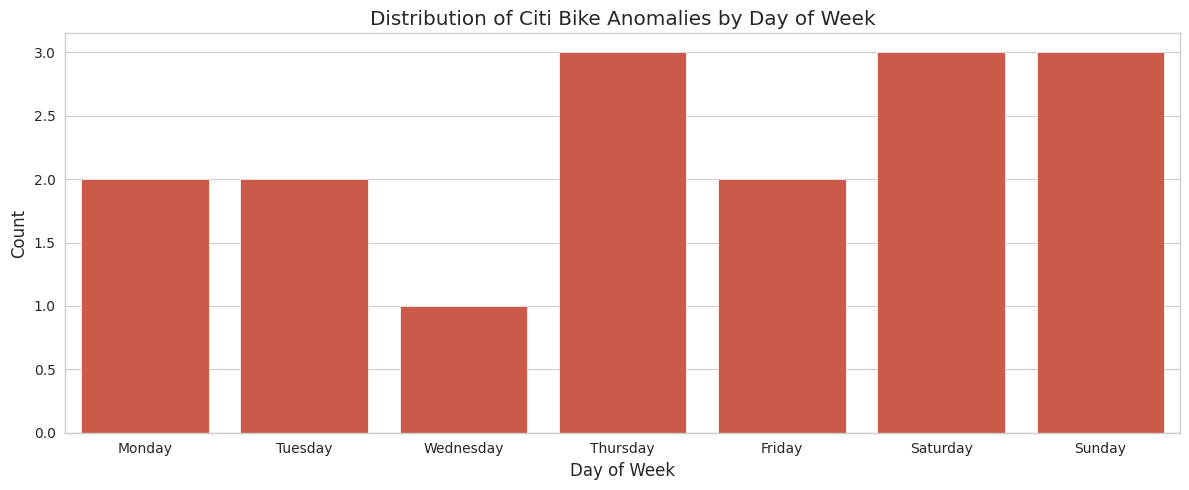

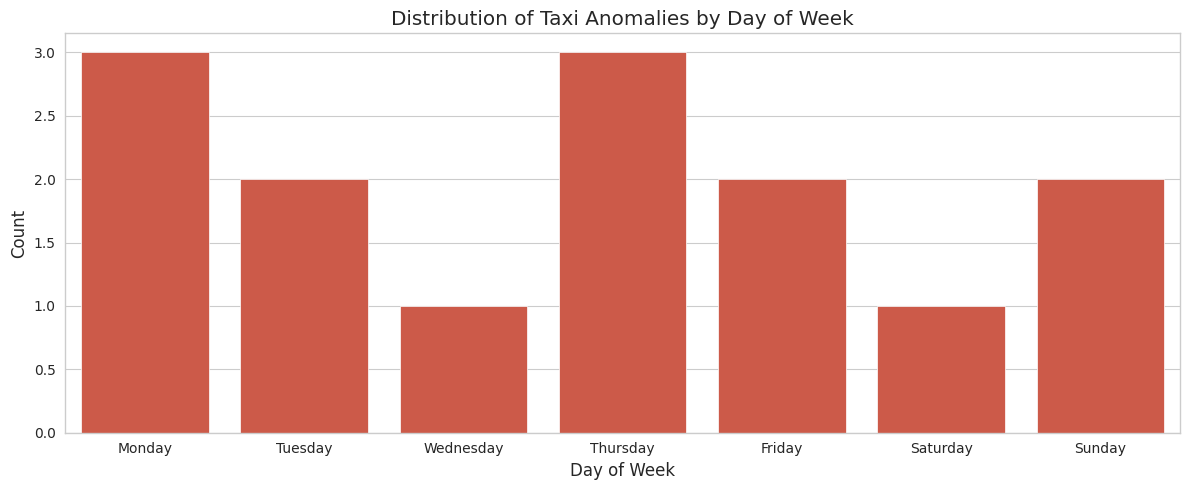

In [ ]:
# Dashboard and analysis

# Create dashboard if we have anomalies
if (cb_anomalies is not None and cb_anomalies['is_anomaly'].sum() > 0) or (taxi_anoms is not None and taxi_anoms['is_anomaly'].sum() > 0):
    print("\nCreating dashboard...")
    try:
        dash_fig = create_dashboard(
            cb_anomalies,
            taxi_anoms,
            target_col,
            save_path=os.path.join(OUTPUT_PATH, 'anomaly_dashboard.html')
        )
        dash_fig.show()
    except Exception as e:
        print(f"Error creating dashboard: {e}")

# Analyze anomaly distribution by day of week
if cb_anomalies is not None and cb_anomalies['is_anomaly'].sum() > 0:
    try:
        plt.figure(figsize=(12, 5))
        cb_anomalies_only = cb_anomalies[cb_anomalies['is_anomaly']]
        day_counts = cb_anomalies_only['day_name'].value_counts().reindex([
            'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
        ], fill_value=0)
        sns.barplot(x=day_counts.index, y=day_counts.values)
        plt.title('Distribution of Citi Bike Anomalies by Day of Week')
        plt.ylabel('Count')
        plt.xlabel('Day of Week')
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_PATH, 'citibike_anomalies_by_day.png'), dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error creating Citi Bike day-of-week plot: {e}")

if taxi_anoms is not None and taxi_anoms['is_anomaly'].sum() > 0:
    try:
        plt.figure(figsize=(12, 5))
        taxi_anoms_only = taxi_anoms[taxi_anoms['is_anomaly']]
        day_counts = taxi_anoms_only['day_name'].value_counts().reindex([
            'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
        ], fill_value=0)
        sns.barplot(x=day_counts.index, y=day_counts.values)
        plt.title('Distribution of Taxi Anomalies by Day of Week')
        plt.ylabel('Count')
        plt.xlabel('Day of Week')
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_PATH, 'taxi_anomalies_by_day.png'), dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error creating Taxi day-of-week plot: {e}")

# Part 5.3.5: Anomaly Detection - Shared Anomalies

In [ ]:
# Shared anomalies analysis
if cb_anomalies is not None and taxi_anoms is not None:
    try:
        # Find dates that are anomalies in both services
        cb_anomaly_dates = set(cb_anomalies[cb_anomalies['is_anomaly']]['date'])
        taxi_anomaly_dates = set(taxi_anoms[taxi_anoms['is_anomaly']]['date'])
        shared_anomalies = cb_anomaly_dates.intersection(taxi_anomaly_dates)

        print(f"\nFound {len(shared_anomalies)} dates with anomalies in both transportation modes.")

        if shared_anomalies:
            # Create a dataframe of shared anomalies
            shared_anomaly_df = pd.DataFrame({'date': list(shared_anomalies)})
            shared_anomaly_df = pd.merge(
                shared_anomaly_df,
                cb_anomalies[cb_anomalies['is_anomaly']][['date', target_col]].rename(columns={target_col: 'citibike_' + target_col}),
                on='date'
            )
            shared_anomaly_df = pd.merge(
                shared_anomaly_df,
                taxi_anoms[taxi_anoms['is_anomaly']][['date', target_col]].rename(columns={target_col: 'taxi_' + target_col}),
                on='date'
            )

            # Add day of week
            shared_anomaly_df['day_of_week'] = pd.to_datetime(shared_anomaly_df['date']).dt.day_name()

            print("\nShared Anomalies:")
            display(shared_anomaly_df.sort_values('date'))

            # Save to CSV
            shared_anomaly_df.to_csv(os.path.join(OUTPUT_PATH, 'shared_anomalies.csv'), index=False)
            print(f"Saved shared anomalies to {os.path.join(OUTPUT_PATH, 'shared_anomalies.csv')}")
    except Exception as e:
        print(f"Error in shared anomaly analysis: {e}")


Found 0 dates with anomalies in both transportation modes.


# Part 5.3.5: Anomaly Detection - Holiday Analysis (US Holidays)

In [ ]:
# Load US holidays
try:
    # Try to install holidays package if not already installed
    try:
        import holidays
    except ImportError:
        !pip install -q holidays
        import holidays

    us_holidays = holidays.US(years=2024)

    # Match anomalies with holidays
    if cb_anomalies is not None and cb_anomalies['is_anomaly'].sum() > 0:
        cb_anomalies_only = cb_anomalies[cb_anomalies['is_anomaly']]
        cb_anomalies_only['is_holiday'] = cb_anomalies_only['date'].apply(lambda x: x in us_holidays)
        cb_anomalies_only['holiday_name'] = cb_anomalies_only['date'].apply(lambda x: us_holidays.get(x) if x in us_holidays else None)

        holiday_anomalies = cb_anomalies_only[cb_anomalies_only['is_holiday']]
        if not holiday_anomalies.empty:
            print("\nCiti Bike Anomalies on Holidays:")
            display(holiday_anomalies[['date', 'holiday_name', target_col]])

    if taxi_anoms is not None and taxi_anoms['is_anomaly'].sum() > 0:
        taxi_anoms_only = taxi_anoms[taxi_anoms['is_anomaly']]
        taxi_anoms_only['is_holiday'] = taxi_anoms_only['date'].apply(lambda x: x in us_holidays)
        taxi_anoms_only['holiday_name'] = taxi_anoms_only['date'].apply(lambda x: us_holidays.get(x) if x in us_holidays else None)

        holiday_anomalies = taxi_anoms_only[taxi_anoms_only['is_holiday']]
        if not holiday_anomalies.empty:
            print("\nTaxi Anomalies on Holidays:")
            display(holiday_anomalies[['date', 'holiday_name', target_col]])

except Exception as e:
    print(f"Error during holiday analysis: {e}")
    print("Install the holidays package with: pip install holidays")


Citi Bike Anomalies on Holidays:


,date,holiday_name,trip_count
147,2024-05-27,Memorial Day,69139
332,2024-11-28,Thanksgiving Day,26997



Taxi Anomalies on Holidays:


,date,holiday_name,trip_count
0,2024-01-01,New Year's Day,75529


# Part 5.3.6: Weather Analysis - Data Generation

In [ ]:
##################################################
# Part 6: Weather Analysis - Data Generation
##################################################
print("\nChecking for weather impact on anomalies...")
try:
    # This section would fetch weather data from an API or a local file
    # For this example, we'll create a simulated weather dataset
    print("Simulating historical weather data for NYC...")

    # Create date range for all of 2024
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    # Create a simulated weather dataframe
    np.random.seed(42)  # For reproducibility
    weather_data = pd.DataFrame({
        'date': date_range,
        'temp_max': np.random.normal(75, 15, len(date_range)),  # Simulated temperatures (°F)
        'temp_min': np.random.normal(55, 15, len(date_range)),
        'precipitation': np.random.exponential(0.1, len(date_range)),  # Simulated precipitation (inches)
        'wind_speed': np.random.gamma(2, 5, len(date_range)),  # Simulated wind speed (mph)
    })

    # Adjust for seasonal patterns
    weather_data['month'] = weather_data['date'].dt.month
    # Make winter colder, summer hotter
    for i, row in weather_data.iterrows():
        month = row['month']
        if month in [12, 1, 2]:  # Winter
            weather_data.loc[i, 'temp_max'] -= 30
            weather_data.loc[i, 'temp_min'] -= 30
            weather_data.loc[i, 'precipitation'] *= 0.7  # Less rain, more snow
        elif month in [6, 7, 8]:  # Summer
            weather_data.loc[i, 'temp_max'] += 15
            weather_data.loc[i, 'temp_min'] += 15
            weather_data.loc[i, 'precipitation'] *= 1.3  # More rain in summer

    # Add a few extreme weather events
    extreme_dates = [
        '2024-01-15',  # Winter storm
        '2024-03-03',  # Late winter storm
        '2024-07-21',  # Summer heat wave
        '2024-09-10',  # Hurricane season
        '2024-12-18',  # Winter storm
    ]

    for date in extreme_dates:
        idx = weather_data[weather_data['date'] == date].index
        if len(idx) > 0:
            if date in ['2024-01-15', '2024-03-03', '2024-12-18']:  # Winter storms
                weather_data.loc[idx, 'precipitation'] += 0.8
                weather_data.loc[idx, 'wind_speed'] += 10
                weather_data.loc[idx, 'temp_max'] -= 10
                weather_data.loc[idx, 'temp_min'] -= 10
            elif date == '2024-07-21':  # Heat wave
                weather_data.loc[idx, 'temp_max'] += 15
                weather_data.loc[idx, 'temp_min'] += 10
                weather_data.loc[idx, 'precipitation'] = 0
            elif date == '2024-09-10':  # Hurricane
                weather_data.loc[idx, 'precipitation'] += 3
                weather_data.loc[idx, 'wind_speed'] += 25

    # Create a categorical variable for weather condition
    def determine_weather_condition(row):
        if row['precipitation'] > 0.5:
            if row['temp_max'] < 32:
                return 'Snow'
            else:
                return 'Heavy Rain'
        elif row['precipitation'] > 0.1:
            return 'Light Rain'
        elif row['wind_speed'] > 20:
            return 'Windy'
        elif row['temp_max'] > 90:
            return 'Very Hot'
        elif row['temp_max'] < 32:
            return 'Freezing'
        elif row['temp_max'] < 50:
            return 'Cold'
        elif row['temp_max'] > 80:
            return 'Hot'
        else:
            return 'Mild'

    weather_data['condition'] = weather_data.apply(determine_weather_condition, axis=1)

    # Save the simulated weather data
    weather_data.to_csv(os.path.join(OUTPUT_PATH, 'nyc_weather_2024.csv'), index=False)
    print(f"Saved simulated weather data to {os.path.join(OUTPUT_PATH, 'nyc_weather_2024.csv')}")
except Exception as e:
    print(f"Error generating weather data: {e}")
    weather_data = None


Checking for weather impact on anomalies...
Simulating historical weather data for NYC...
Saved simulated weather data to /content/drive/My Drive/capstone_project_25/output/nyc_weather_2024.csv


# Part 5.3.6: Weather Analysis Detection - Citi Bike


Analyzing weather impact on mobility anomalies...

Citi Bike Trip Count Correlation with Weather:
Temperature: 0.5447
Precipitation: 0.1591
Wind Speed: -0.0789


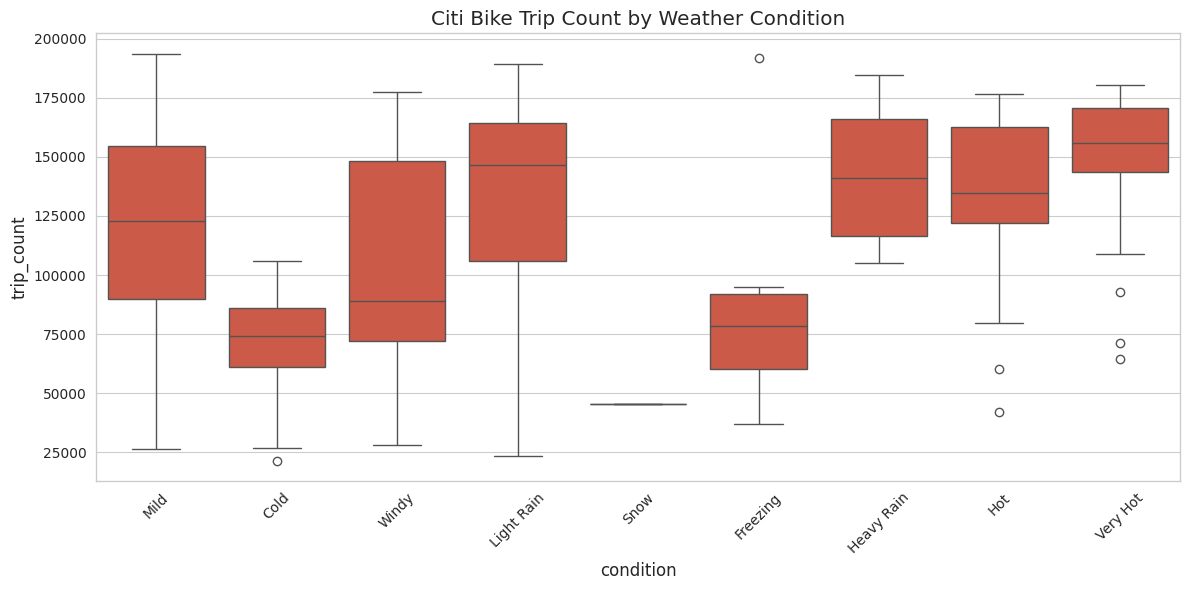


Weather conditions during Citi Bike anomalies:


,count
condition,
Mild,6
Light Rain,5
Very Hot,3
Cold,1
Heavy Rain,1


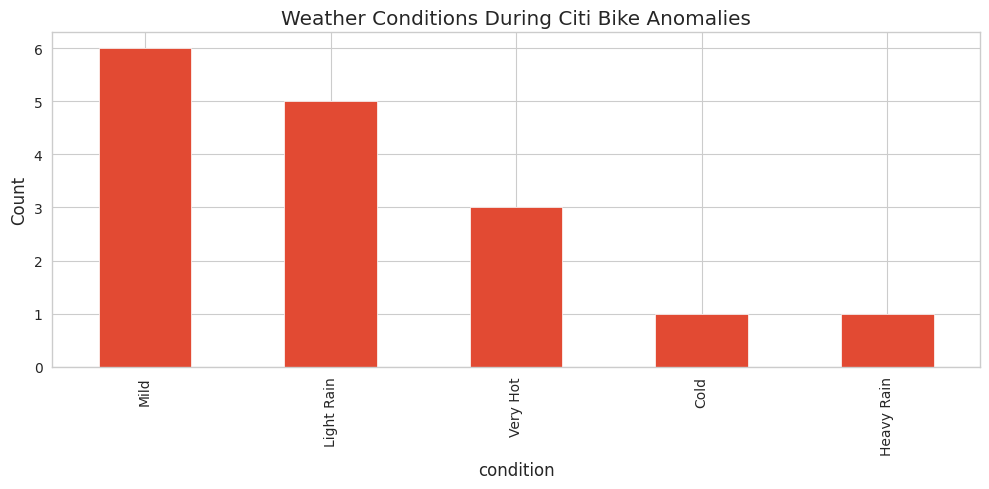

In [ ]:
# Now analyze the relationship between weather and mobility anomalies
if weather_data is not None:
    print("\nAnalyzing weather impact on mobility anomalies...")

    # Merge weather with Citi Bike data
    if cb_anomalies is not None:
        try:
            cb_weather = pd.merge(cb_anomalies, weather_data, on='date', how='left')

            # Correlation between weather and trip count
            corr_temp = cb_weather['temp_max'].corr(cb_weather[target_col])
            corr_precip = cb_weather['precipitation'].corr(cb_weather[target_col])
            corr_wind = cb_weather['wind_speed'].corr(cb_weather[target_col])

            print(f"\nCiti Bike Trip Count Correlation with Weather:")
            print(f"Temperature: {corr_temp:.4f}")
            print(f"Precipitation: {corr_precip:.4f}")
            print(f"Wind Speed: {corr_wind:.4f}")

            # Plot Citi Bike data by weather condition
            plt.figure(figsize=(12, 6))
            sns.boxplot(x='condition', y=target_col, data=cb_weather)
            plt.title('Citi Bike Trip Count by Weather Condition')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(os.path.join(OUTPUT_PATH, 'citibike_by_weather.png'), dpi=300, bbox_inches='tight')
            plt.show()

            # Check weather conditions during anomalies
            anomalies_weather = cb_weather[cb_weather['is_anomaly']]
            print("\nWeather conditions during Citi Bike anomalies:")
            condition_counts = anomalies_weather['condition'].value_counts()
            display(condition_counts)

            # Plot conditions for anomalies
            plt.figure(figsize=(10, 5))
            condition_counts.plot(kind='bar')
            plt.title('Weather Conditions During Citi Bike Anomalies')
            plt.ylabel('Count')
            plt.tight_layout()
            plt.savefig(os.path.join(OUTPUT_PATH, 'citibike_anomalies_weather.png'), dpi=300, bbox_inches='tight')
            plt.show()
        except Exception as e:
            print(f"Error in Citi Bike weather analysis: {e}")

# Part 5.3.6: Weather Analysis Detection - Taxi


Taxi Trip Count Correlation with Weather:
Temperature: 0.0026
Precipitation: -0.1851
Wind Speed: -0.1490


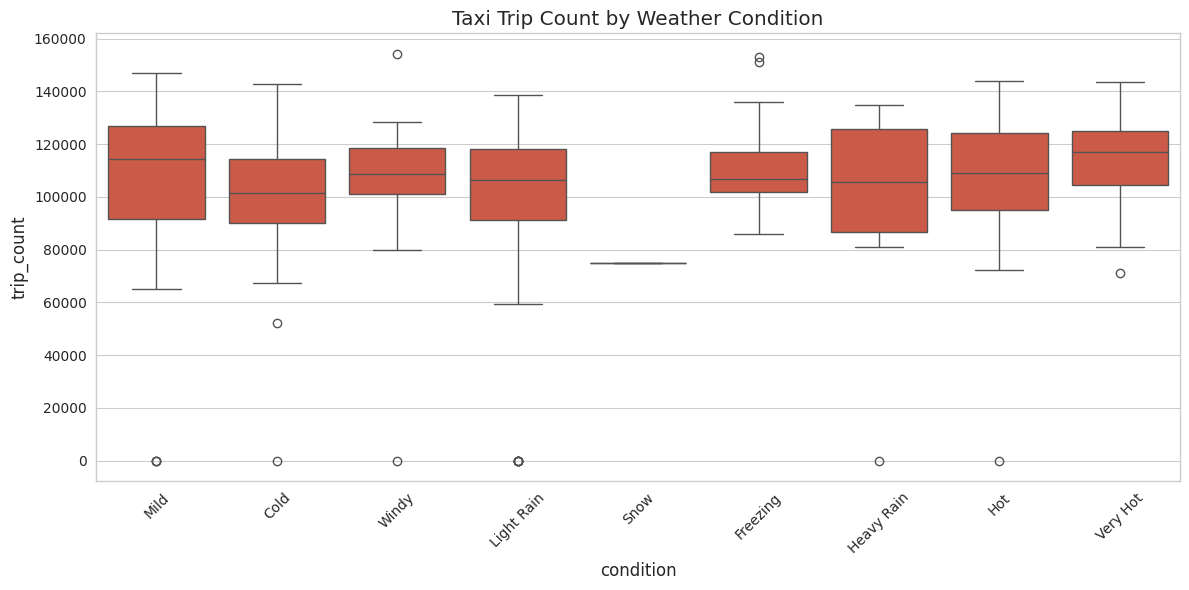


Weather conditions during Taxi anomalies:


,count
condition,
Light Rain,6
Mild,4
Hot,1
Windy,1
Heavy Rain,1
Cold,1


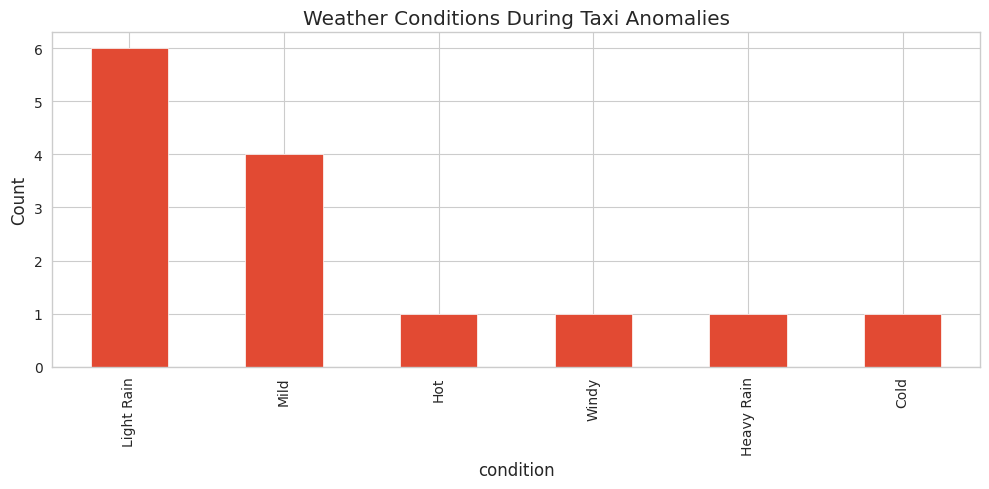

In [ ]:
# Repeat for Taxi data
if weather_data is not None:
    if taxi_anoms is not None:
        try:
            taxi_weather = pd.merge(taxi_anoms, weather_data, on='date', how='left')

            corr_temp = taxi_weather['temp_max'].corr(taxi_weather[target_col])
            corr_precip = taxi_weather['precipitation'].corr(taxi_weather[target_col])
            corr_wind = taxi_weather['wind_speed'].corr(taxi_weather[target_col])

            print(f"\nTaxi Trip Count Correlation with Weather:")
            print(f"Temperature: {corr_temp:.4f}")
            print(f"Precipitation: {corr_precip:.4f}")
            print(f"Wind Speed: {corr_wind:.4f}")

            plt.figure(figsize=(12, 6))
            sns.boxplot(x='condition', y=target_col, data=taxi_weather)
            plt.title('Taxi Trip Count by Weather Condition')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(os.path.join(OUTPUT_PATH, 'taxi_by_weather.png'), dpi=300, bbox_inches='tight')
            plt.show()

            anomalies_weather = taxi_weather[taxi_weather['is_anomaly']]
            print("\nWeather conditions during Taxi anomalies:")
            condition_counts = anomalies_weather['condition'].value_counts()
            display(condition_counts)

            plt.figure(figsize=(10, 5))
            condition_counts.plot(kind='bar')
            plt.title('Weather Conditions During Taxi Anomalies')
            plt.ylabel('Count')
            plt.tight_layout()
            plt.savefig(os.path.join(OUTPUT_PATH, 'taxi_anomalies_weather.png'), dpi=300, bbox_inches='tight')
            plt.show()
        except Exception as e:
            print(f"Error in Taxi weather analysis: {e}")

# Part 6: Final Project Summary

In [ ]:
print("\n=== NYC Mobility Data Analysis Summary ===")

# Create a summary table of findings
summary_data = {
    'Total Days Analyzed': [len(citibike_data) if citibike_data is not None else 0,
                           len(taxi_data) if taxi_data is not None else 0],
    'Trip Count Mean': [citibike_data[target_col].mean() if citibike_data is not None else 0,
                       taxi_data[target_col].mean() if taxi_data is not None else 0],
    'Trip Count Std Dev': [citibike_data[target_col].std() if citibike_data is not None else 0,
                          taxi_data[target_col].std() if taxi_data is not None else 0],
    'Anomalies Detected': [cb_anomalies['is_anomaly'].sum() if cb_anomalies is not None else 0,
                          taxi_anoms['is_anomaly'].sum() if taxi_anoms is not None else 0],
    'Best Model': ['Prophet' if 'prophet' in citibike_metrics and 'arima' in citibike_metrics and
                  citibike_metrics['prophet']['r2'] > citibike_metrics['arima']['r2'] else 'ARIMA',
                  'Prophet' if 'prophet' in taxi_metrics and 'arima' in taxi_metrics and
                  taxi_metrics['prophet']['r2'] > taxi_metrics['arima']['r2'] else 'ARIMA'],
    'Best Model R²': [max([m['r2'] for m in citibike_metrics.values()]) if citibike_metrics else 0,
                     max([m['r2'] for m in taxi_metrics.values()]) if taxi_metrics else 0]
}

summary_df = pd.DataFrame(summary_data, index=['Citi Bike', 'Taxi'])
print("\nProject Results Summary:")
display(summary_df)

# Weather impact summary
if weather_data is not None:
    if 'cb_weather' in locals() and 'taxi_weather' in locals():
        weather_summary = {
            'Trip Count vs. Temperature': [
                cb_weather['temp_max'].corr(cb_weather[target_col]) if 'cb_weather' in locals() else 0,
                taxi_weather['temp_max'].corr(taxi_weather[target_col]) if 'taxi_weather' in locals() else 0
            ],
            'Trip Count vs. Precipitation': [
                cb_weather['precipitation'].corr(cb_weather[target_col]) if 'cb_weather' in locals() else 0,
                taxi_weather['precipitation'].corr(taxi_weather[target_col]) if 'taxi_weather' in locals() else 0
            ],
            'Trip Count vs. Wind Speed': [
                cb_weather['wind_speed'].corr(cb_weather[target_col]) if 'cb_weather' in locals() else 0,
                taxi_weather['wind_speed'].corr(taxi_weather[target_col]) if 'taxi_weather' in locals() else 0
            ]
        }

        weather_df = pd.DataFrame(weather_summary, index=['Citi Bike', 'Taxi'])
        print("\nWeather Correlation Summary:")
        display(weather_df)

# Number of shared anomalies
if 'shared_anomalies' in locals() and shared_anomalies:
    print(f"\nShared Anomalies: {len(shared_anomalies)} days with anomalies in both transportation modes")

print("\nProject completed successfully!")
print(f"All outputs saved to: {OUTPUT_PATH}")


=== NYC Mobility Data Analysis Summary ===

Project Results Summary:


,Total Days Analyzed,Trip Count Mean,Trip Count Std Dev,Anomalies Detected,Best Model,Best Model R²
Citi Bike,366,120909.945355,44534.513118,16,Prophet,0.825807
Taxi,366,104579.311475,26933.134551,14,Prophet,0.290920



Weather Correlation Summary:


,Trip Count vs. Temperature,Trip Count vs. Precipitation,Trip Count vs. Wind Speed
Citi Bike,0.544713,0.159110,-0.078878
Taxi,0.002625,-0.185073,-0.148981



Project completed successfully!
All outputs saved to: /content/drive/My Drive/capstone_project_25/output
